In [1]:
from pathlib import Path
import pandas as pd
from datetime import datetime

#use concat to merge all of files together
list_stacked = pd.DataFrame() 
current_path = Path()/'CSV'
for folder in current_path.absolute().glob('*'):
    for file in folder.glob('H_lvr_land_A.csv'):
        data = pd.read_csv(file)[1:]
        list_stacked = pd.concat([list_stacked, data])

#----------------------------------------------------------------------------------------------------------------------------
#Originally, there are 33 columns in the file; select 18 columns which need to be analyzed
data = list_stacked[['鄉鎮市區', '土地位置建物門牌', '土地移轉總面積平方公尺', '交易年月日', '總樓層數', '建物型態', '建物移轉總面積平方公尺', '總價元',
                     '單價元平方公尺', '主建物面積']]

#----------------------------------------------------------------------------------------------------------------------------
#坪 is the most popular unit that Taiwanese to measure the property, so we need to transfer from meter squared to 坪
data = data.copy()
data = data[data['鄉鎮市區'].notna()]
data['土地移轉總面積坪'] = data['土地移轉總面積平方公尺'].astype(float)*3.3058
data['建物移轉總面積坪'] = data['建物移轉總面積平方公尺'].astype(float)*3.3058
data['單價元坪'] = data['單價元平方公尺'].astype(float)*3.3058
data['主建物面積'] = data['主建物面積'].astype(float)*3.3058
data['總價元'] = data['總價元'].astype(float)
data['交易年月日'] = pd.to_datetime((data['交易年月日'].astype(int)+19110000).astype(str), format = '%Y%m%d', errors='coerce') #轉換成日期型態
condition = (data['交易年月日'] >= '2020-10-01') & (data['交易年月日'] <= '2023-09-30') # 篩選資料，只篩選過去36個月的資料
data = data[condition]

data['Year'] = data['交易年月日'].dt.year.fillna(0).astype(int)
data['Quarter'] = data['交易年月日'].dt.quarter.fillna(0).astype(int)
data['Month'] = data['交易年月日'].dt.month.fillna(0).astype(int).map("{:02}".format)
data['Day'] = data['交易年月日'].dt.day.fillna(0).astype(int)

# # #----------------------------------------------------------------------------------------------------------------------------

data = data.where(pd.notnull(data), None)


In [2]:
lst = []
for year, month in zip(data['Year'],data['Month']):
    lst.append('-'.join(str(i) for i in [year, month]))
data['Yearmonth'] = lst
data['Yearmonth'] = pd.to_datetime(data['Yearmonth'], format='%Y-%m').dt.to_period('M')


In [3]:
# dataset2，使用者自行選擇產業，之後依ROE排序列印出來
# 判斷使用者使用環境
from sys import platform
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

if platform == 'darwin':
    # 設定中文字體
    plt.rcParams['font.family'] = 'Arial Unicode MS'  # 使用 macOS 的內建中文字體

    # 使用中文字體
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

elif platform == 'win32':
    # 设置中文字体路径
    font_path = r'C:\Windows\Fonts'  # 替换为你下载的中文字体文件路径

    # 设置中文字体
    custom_font = FontProperties(fname=font_path)

    # 使用中文字体
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 替換為你選擇的繁體中文字體
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
import numpy as np

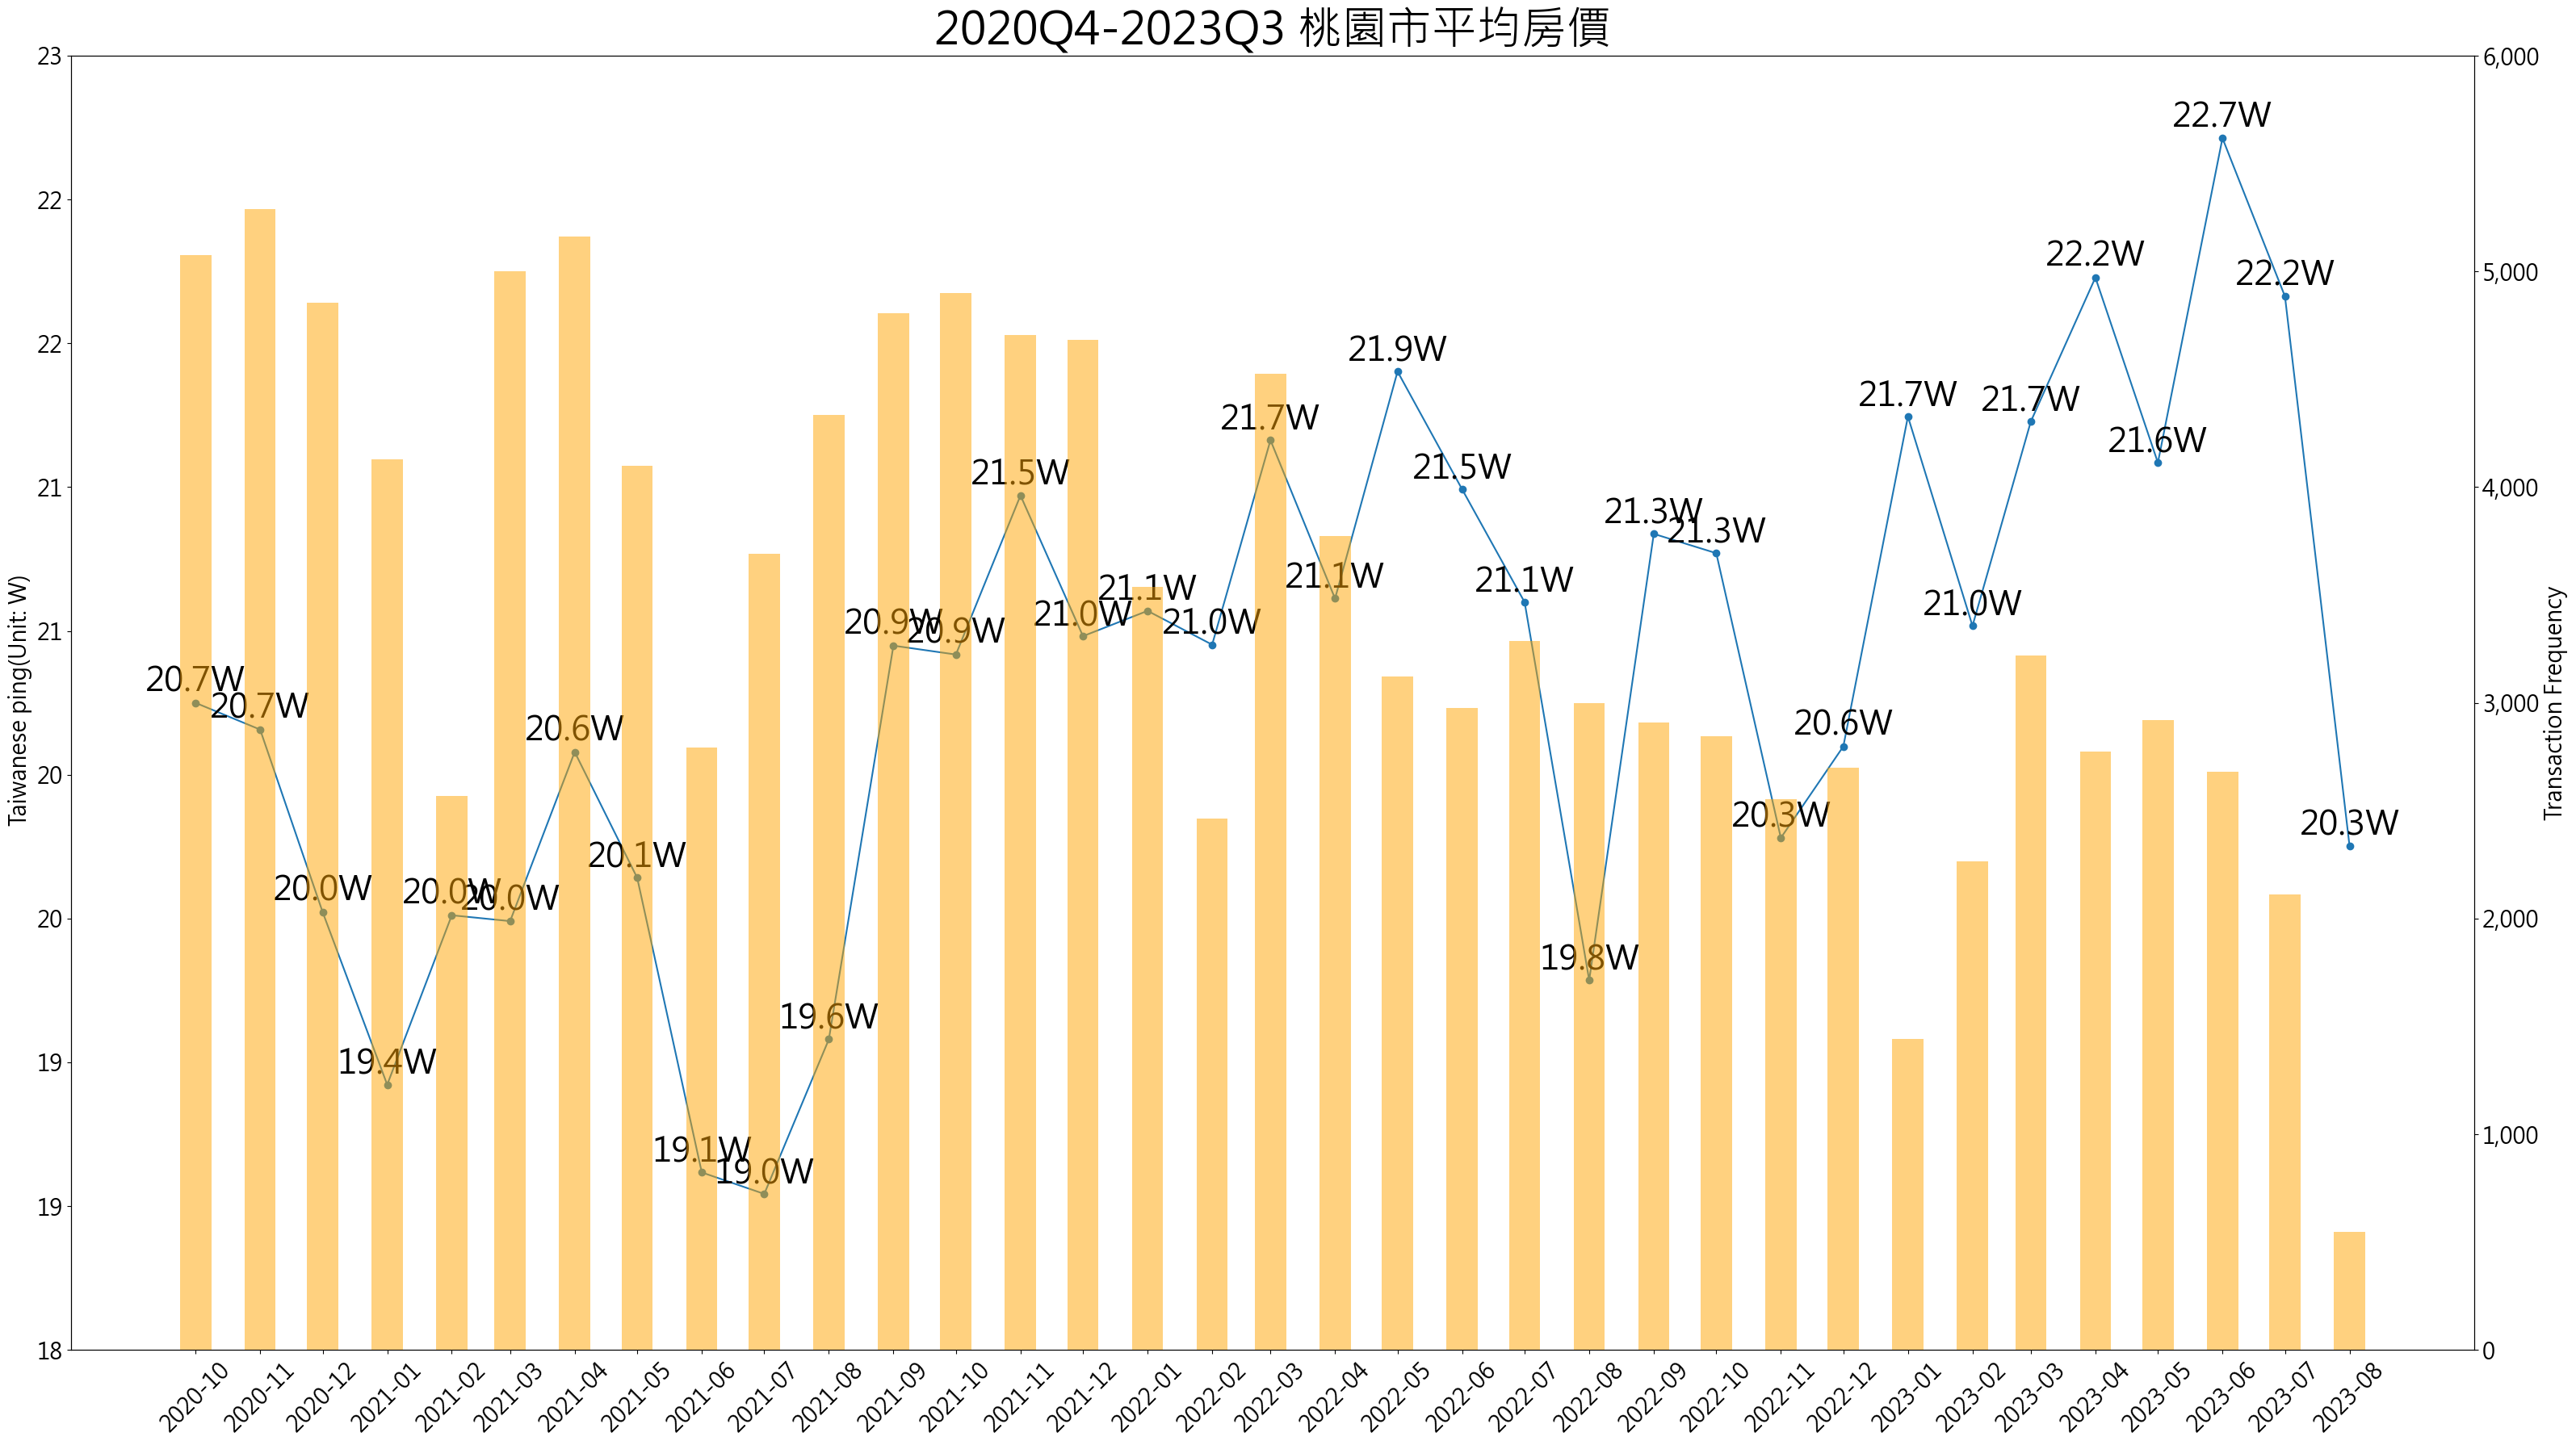

In [18]:
from matplotlib.dates import date2num
from datetime import datetime
import matplotlib.pyplot as plt
from pathlib import Path

# Assuming 'data' and 'lst' are defined somewhere in your code
# Adjust the code accordingly if necessary

x_values = sorted(set(lst))
dates = [datetime.strptime(date, '%Y-%m') for date in x_values]
x_values_numeric = date2num(dates)

y = list(data.groupby(['Yearmonth'])['單價元坪'].mean())
y_values = [int(i) / 10000 for i in y]

# Count the number of entries for each unique year-month combination
entry_counts = data['Yearmonth'].value_counts().sort_index()

# Plotting
fig, ax1 = plt.subplots(figsize=(32, 18))

# Line chart
ax1.plot(x_values_numeric, y_values, marker='o', label='Average Price')

# Set the x-axis ticks to be the original date strings
ax1.set_xticks(dates)
ax1.set_xticklabels(x_values, rotation=45, fontsize=20)

# Add labels and title for the line chart
ax1.set_ylabel('Taiwanese ping(Unit: W, 1W = 10K)', fontsize=20)

# Set y-axis ticks and labels
ax1.set_yticks(ax1.get_yticks())
ax1.set_yticklabels([f'{int(i):,}' for i in ax1.get_yticks()], fontsize=20)

title = '2020Q4-2023Q3 桃園市平均房價'
ax1.set_title(title, fontsize=40)

# Annotate the data points on the line chart
for i, txt in enumerate(y_values):
    ax1.annotate(f'{txt:.1f}W', (x_values_numeric[i], y_values[i]),
                 textcoords="offset points", xytext=(0, 10), ha='center', size=30)

# Bar chart
ax2 = ax1.twinx()  # Create a second y-axis to overlay the bar chart
ax2.bar(x_values_numeric, entry_counts, alpha=0.5, color='orange', width=15)

# Add labels and title for the bar chart
ax2.set_ylabel('Transaction Frequency', fontsize=20)

# Set y-axis ticks and labels for the second y-axis
ax2.set_yticks(ax2.get_yticks())
ax2.set_yticklabels([f'{int(i):,}' for i in ax2.get_yticks()], fontsize=20)

# Adjust layout to prevent label overlap
fig.tight_layout()


# save the plot with title named
path_to_save_file = Path().absolute()/"PNG"
path_to_save_file.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
filename = f'{title}.png'
full_path = path_to_save_file/filename
plt.savefig(full_path)

# Show the chart
plt.show()


In [6]:
# # # #----------------------------------------------------------------------------------------------------------------------------
data_transpose = pd.DataFrame({'Price': y_values, 'Count': entry_counts})
data_transpose['Price'] = data_transpose['Price'].round(1)
data_transpose['Count'] = data_transpose['Count'].apply(lambda x: f'{x:.0f}')
data_transpose.transpose()


Yearmonth 2020-10 2020-11 2020-12 2021-01 2021-02 2021-03 2021-04 2021-05  \
Price        20.7    20.7    20.0    19.4    20.0    20.0    20.6    20.1   
Count        5077    5288    4855    4128    2569    5001    5160    4100   

Yearmonth 2021-06 2021-07  ... 2022-11 2022-12 2023-01 2023-02 2023-03  \
Price        19.1    19.0  ...    20.3    20.6    21.7    21.0    21.7   
Count        2794    3691  ...    2555    2701    1440    2265    3218   

Yearmonth 2023-04 2023-05 2023-06 2023-07 2023-08  
Price        22.2    21.6    22.7    22.2    20.3  
Count        2774    2920    2679    2113     548  

[2 rows x 35 columns]

In [7]:
transaction_area = data['鄉鎮市區'].value_counts().reset_index()
transaction_area = transaction_area.sort_values(by='count', ascending=False).reset_index(drop=True)


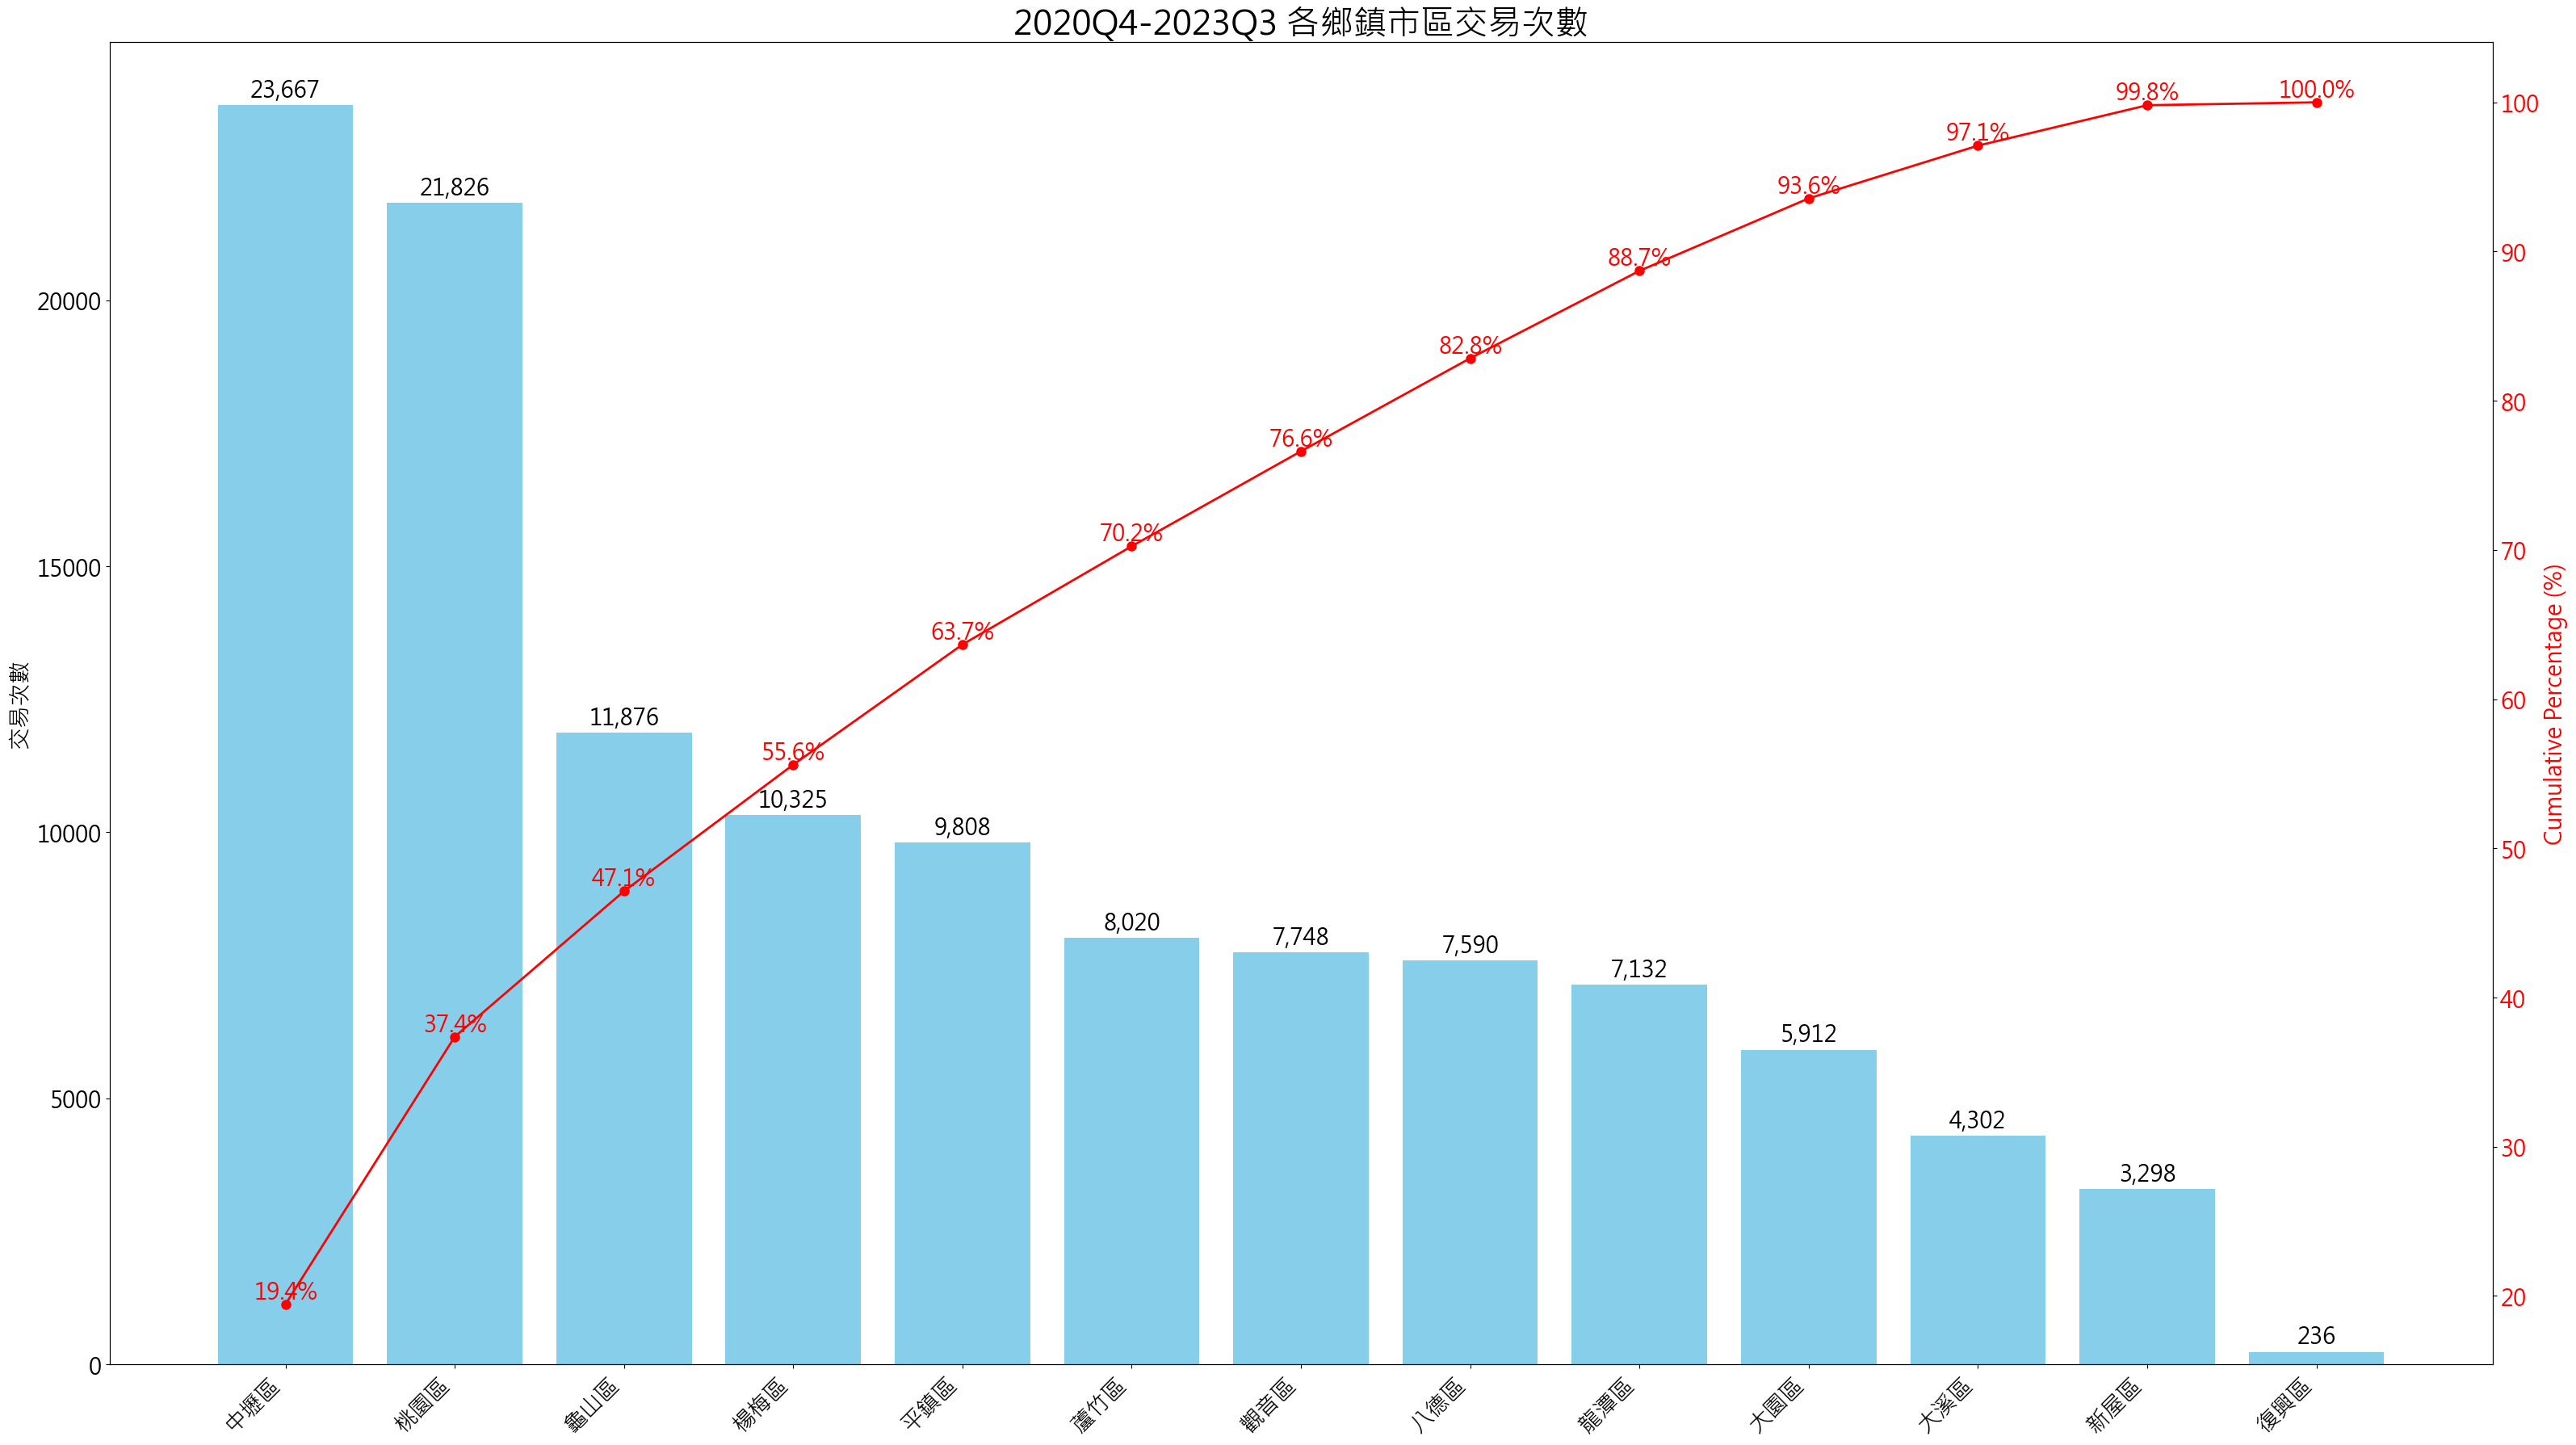

In [8]:
# Create a DataFrame
ta = pd.DataFrame(transaction_area)

# Sort DataFrame by count in descending order
ta = ta.sort_values(by='count', ascending=False)

# Calculate cumulative percentage
ta['cum_percentage'] = ta['count'].cumsum() / ta['count'].sum() * 100

# Plot the bar chart and cumulative percentage line
fig, ax1 = plt.subplots(figsize=(32, 18))
bars = ax1.bar(ta['鄉鎮市區'], ta['count'], color='skyblue')

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 50, f'{yval:,}', ha='center', va='bottom', fontsize=20)

# Add labels and title
ax1.set_ylabel('Transaction Frequency', fontsize=20)
title = '2020Q4-2023Q3 各鄉鎮市區Transaction Frequency'
ax1.set_title(title, fontsize=30)

# Set tick positions and labels for the x-axis
ax1.set_xticks(ta.index)
ax1.set_xticklabels(ta['鄉鎮市區'], rotation=45, ha='right', fontsize=20)

ax1.tick_params(axis='y', labelsize=20)

# Create a secondary Y-axis for the cumulative percentage line
ax2 = ax1.twinx()
ax2.plot(ta.index, ta['cum_percentage'], color='red', marker='o', linestyle='-', linewidth=2, markersize=8)

# Add percentage data labels on the line
for x, y in zip(ta.index, ta['cum_percentage']):
    ax2.text(x, y, f'{y:.1f}%', ha='center', va='bottom', fontsize=20, color='red')

ax2.set_ylabel('Cumulative Percentage (%)', color='red', fontsize=20)
ax2.tick_params(axis='y', labelcolor='red', labelsize=20)

# save the plot with title named
path_to_save_file = Path().absolute()/"PNG"
path_to_save_file.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
filename = f'{title}.png'
full_path = path_to_save_file/filename
plt.savefig(full_path)

# Show the plot
plt.tight_layout()
plt.show()


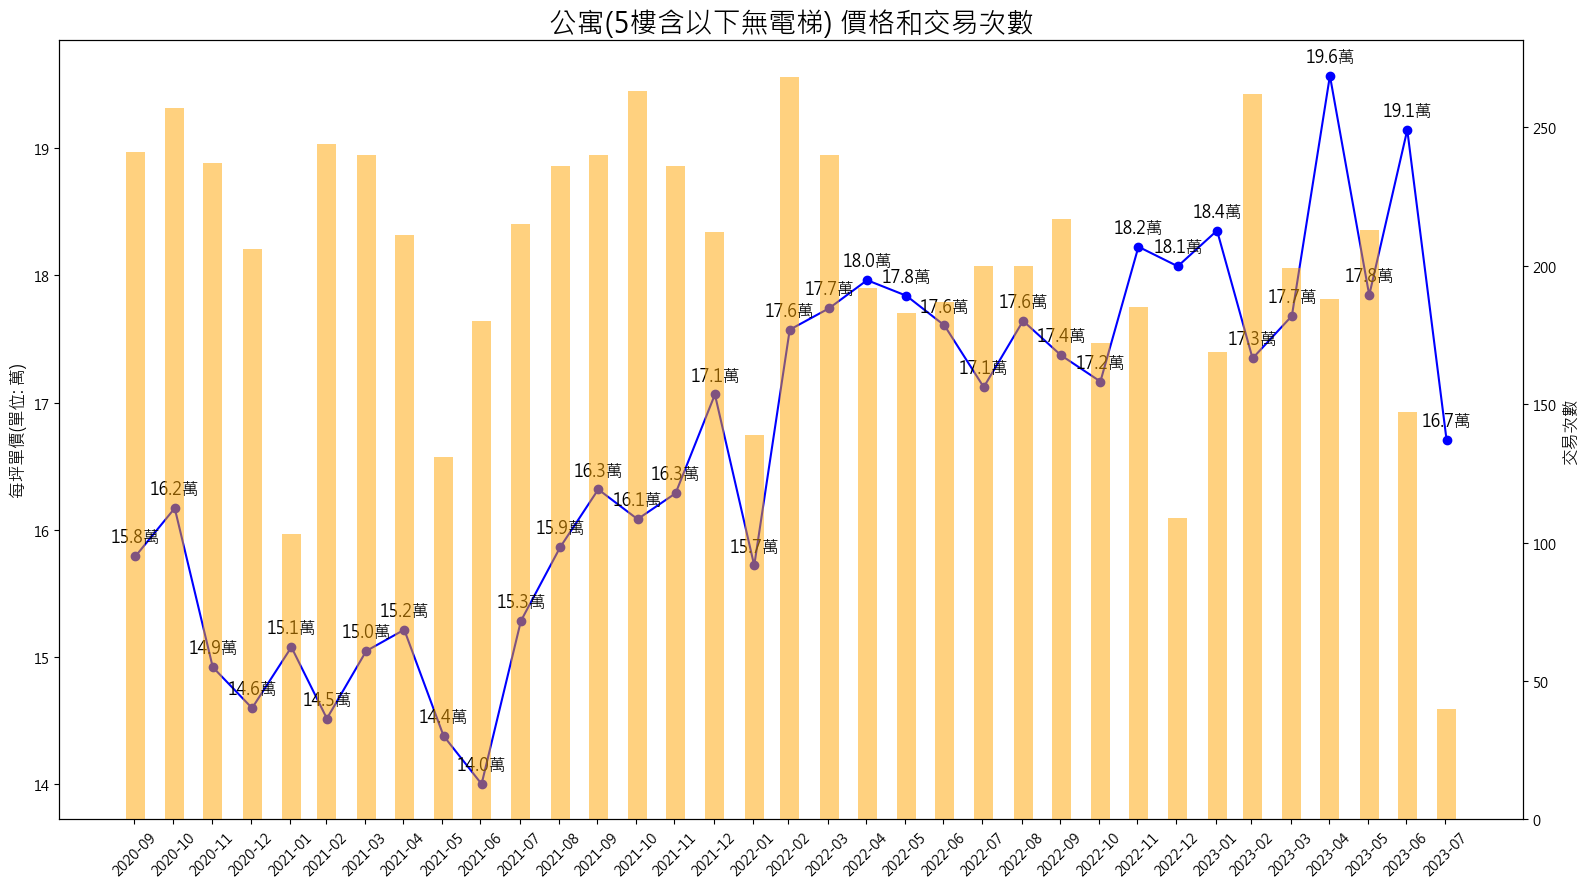

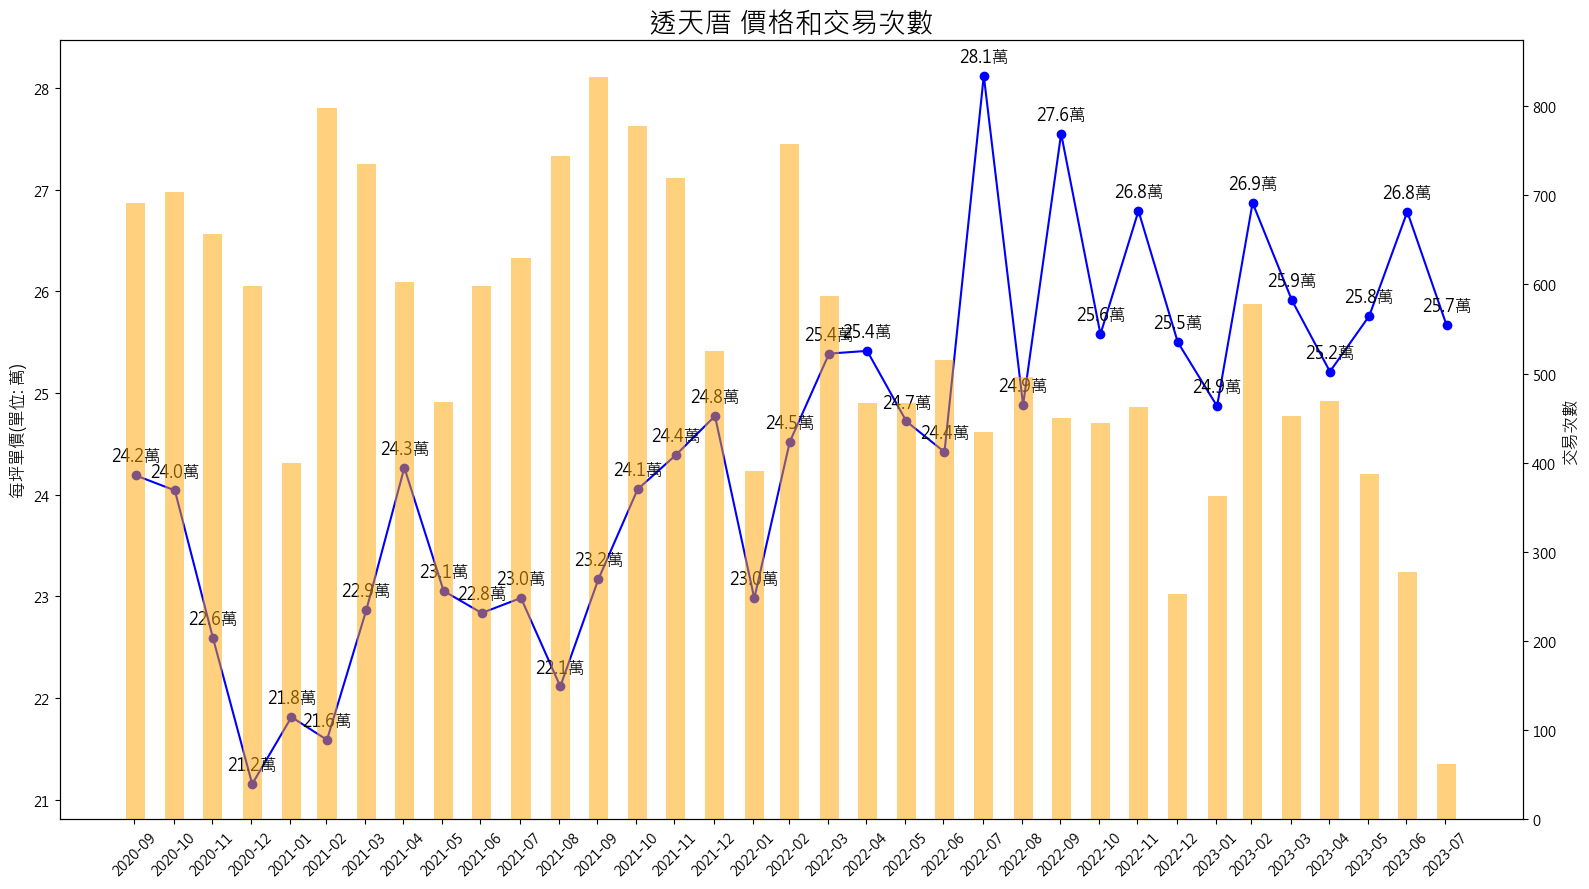

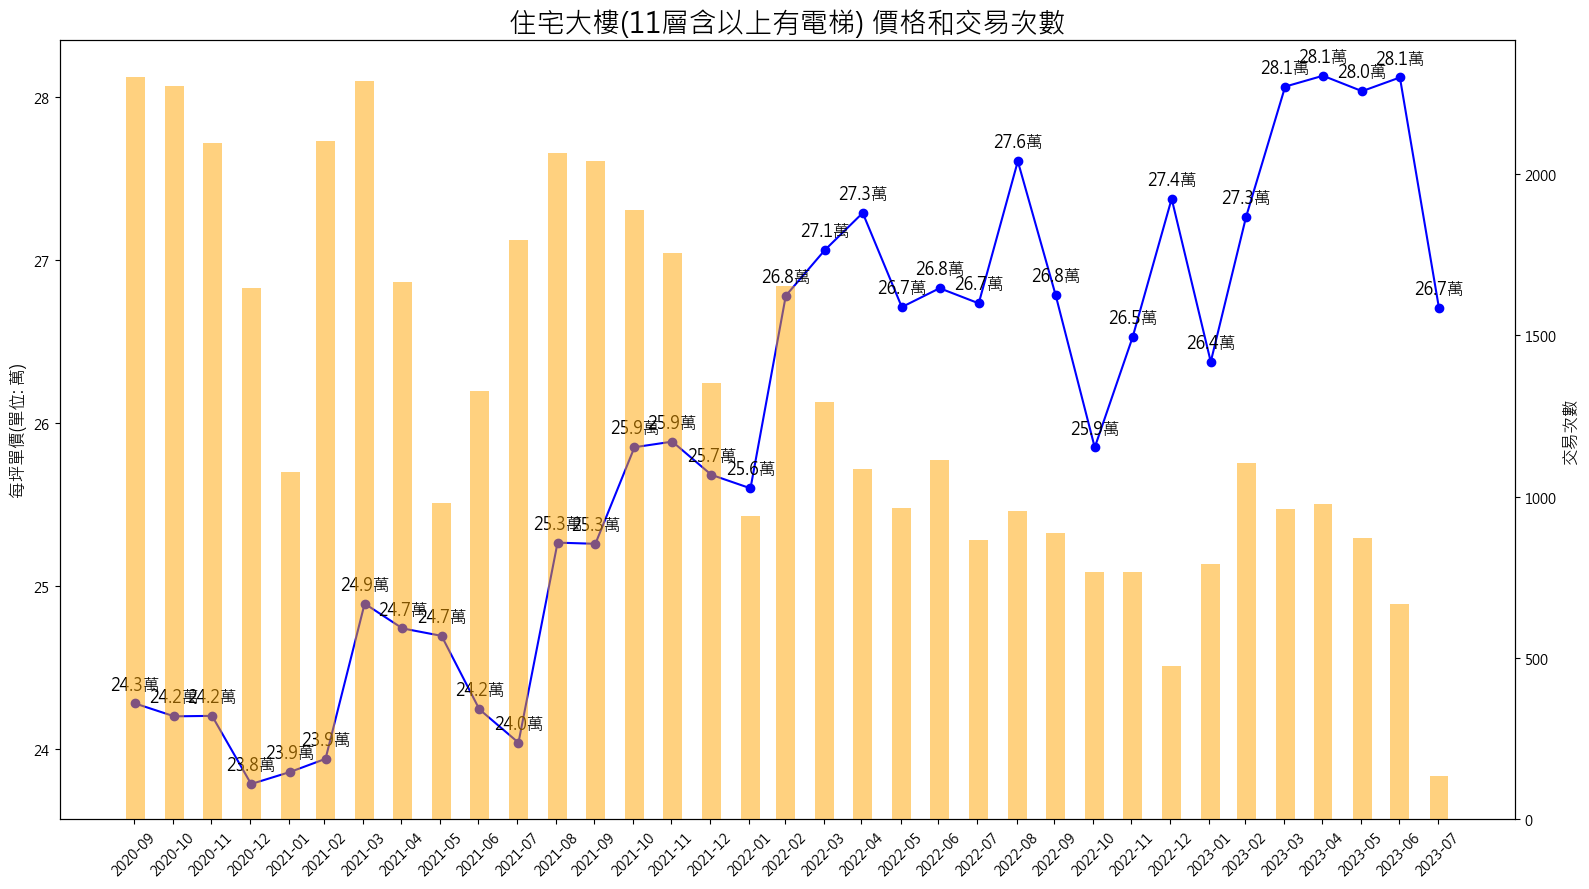

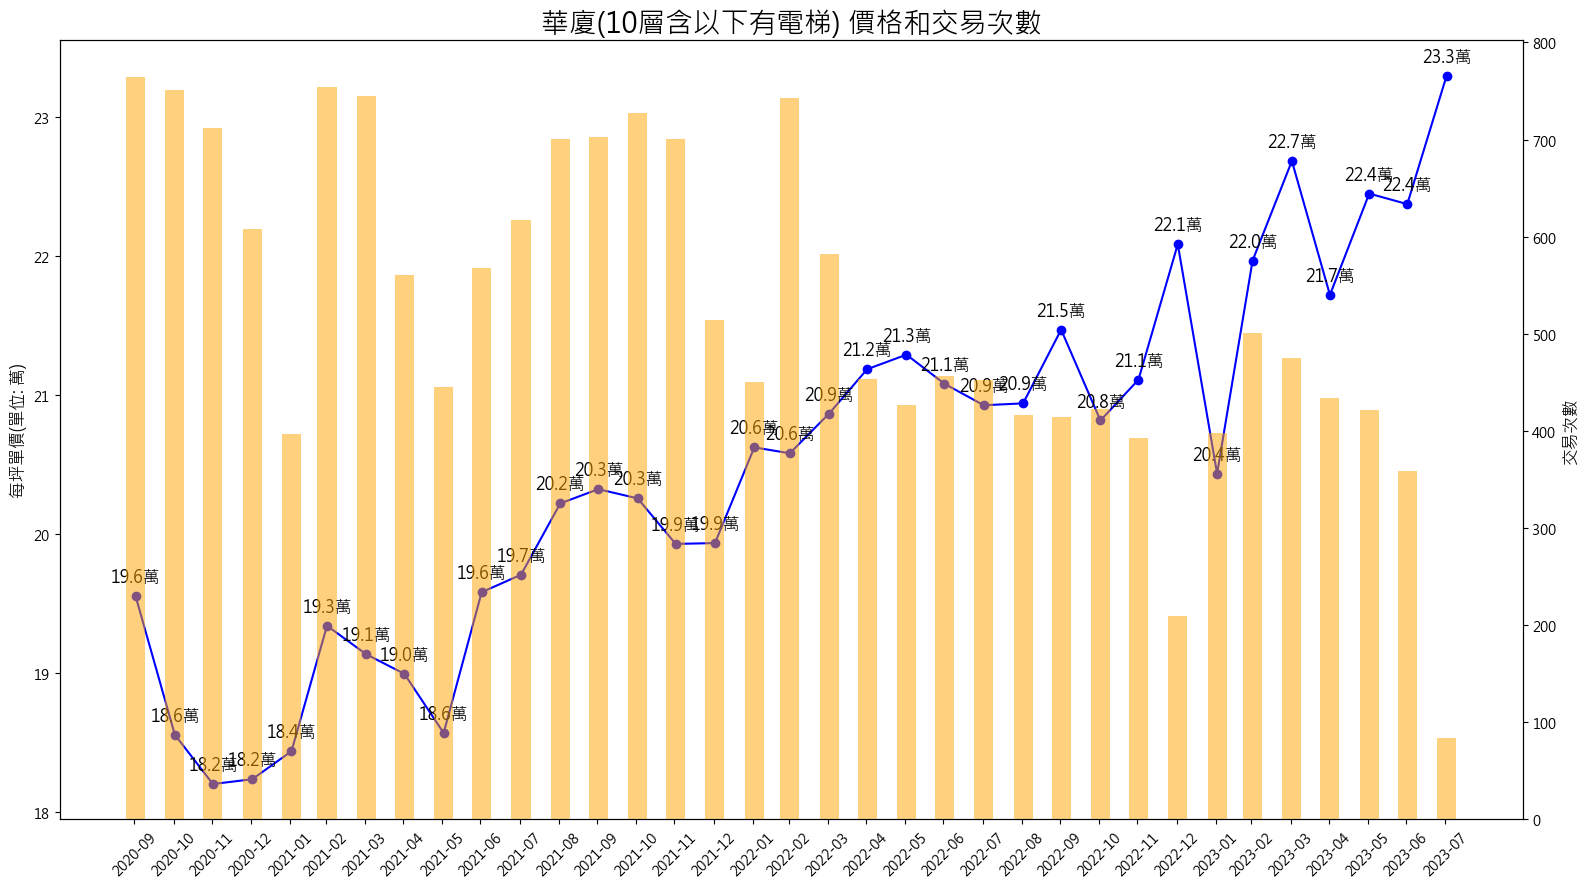

In [9]:
# Create a new DataFrame 'data2'
data2 = pd.DataFrame(data.groupby(['建物型態', 'Yearmonth'])['單價元坪'].mean()).reset_index()
data2['單價元坪'] = data2['單價元坪'] / 10000
property_type = ['公寓(5樓含以下無電梯)', '透天厝', '住宅大樓(11層含以上有電梯)', '華廈(10層含以下有電梯)']

for type in property_type:
    # Create a copy of data2
    data2_copy = data2[data2['建物型態'] == type]

    # Convert the Yearmonth column to datetime
    data2_copy.loc[:, 'Yearmonth'] = pd.to_datetime(data2_copy['Yearmonth'].astype(str), format='%Y-%m')

    # Sort the data by Yearmonth
    data2_copy = data2_copy.sort_values(by='Yearmonth')

    # Create a figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(16, 9))

    # Line chart for average price
    ax1.plot(data2_copy['Yearmonth'], data2_copy['單價元坪'], marker='o', linestyle='-', color='b', label='Average Price')
    ax1.set_ylabel(' Taiwanese ping(Unit: W)', fontsize=12)
    title = f'{type} 價格和Transaction Frequency'
    ax1.set_title(title, fontsize=20)
    ax1.tick_params(axis='x', labelrotation=45)

    # Annotate the data points on the line chart with data labels
    for i, txt in enumerate(data2_copy['單價元坪']):
        ax1.annotate(f'{txt:.1f}W', (data2_copy['Yearmonth'].iloc[i], data2_copy['單價元坪'].iloc[i]),
                     textcoords="offset points", xytext=(0, 10), ha='center', size=12)

    # Create a second y-axis for the bar chart
    ax2 = ax1.twinx()
    
    # Bar chart for entry counts
    entry_counts = data[data['建物型態'] == type]['Yearmonth'].value_counts().sort_index()
    ax2.bar(data2_copy['Yearmonth'], entry_counts, alpha=0.5, color='orange', width=15, label='Entry Counts')
    ax2.set_ylabel('Transaction Frequency', fontsize=12)

    # Set the x-axis ticks and labels to display from September 2020 to August 2023
    ax1.set_xticks(pd.date_range('2020-09-01', '2023-08-01', freq='M'))
    ax1.set_xticklabels([date.strftime('%Y-%m') for date in pd.date_range('2020-09-01', '2023-08-01', freq='M')],
                        rotation=45)

    # Adjust layout to prevent label overlap
    fig.tight_layout()

    # save the plot with title named
    path_to_save_file = Path().absolute()/"PNG"
    path_to_save_file.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
    filename = f'{title}.png'
    full_path = path_to_save_file/filename
    plt.savefig(full_path)

    # Show the chart
    plt.show()

In [10]:
for type in property_type:
    # Create a copy of data2
    data2_copy = data.copy()
    data2_copy = data2_copy[data2_copy['建物型態'] == type].groupby(['建物型態', 'Yearmonth']).size().reset_index(name='Transaction_Count')
    print(type)
    print(data2_copy[['Yearmonth', 'Transaction_Count']].transpose())

公寓(5樓含以下無電梯)
                        0        1        2        3        4        5   \
Yearmonth          2020-10  2020-11  2020-12  2021-01  2021-02  2021-03   
Transaction_Count      241      257      237      206      103      244   

                        6        7        8        9   ...       25       26  \
Yearmonth          2021-04  2021-05  2021-06  2021-07  ...  2022-11  2022-12   
Transaction_Count      240      211      131      180  ...      172      185   

                        27       28       29       30       31       32  \
Yearmonth          2023-01  2023-02  2023-03  2023-04  2023-05  2023-06   
Transaction_Count      109      169      262      199      188      213   

                        33       34  
Yearmonth          2023-07  2023-08  
Transaction_Count      147       40  

[2 rows x 35 columns]
透天厝
                        0        1        2        3        4        5   \
Yearmonth          2020-10  2020-11  2020-12  2021-01  2021-02  2021-03   
Tra

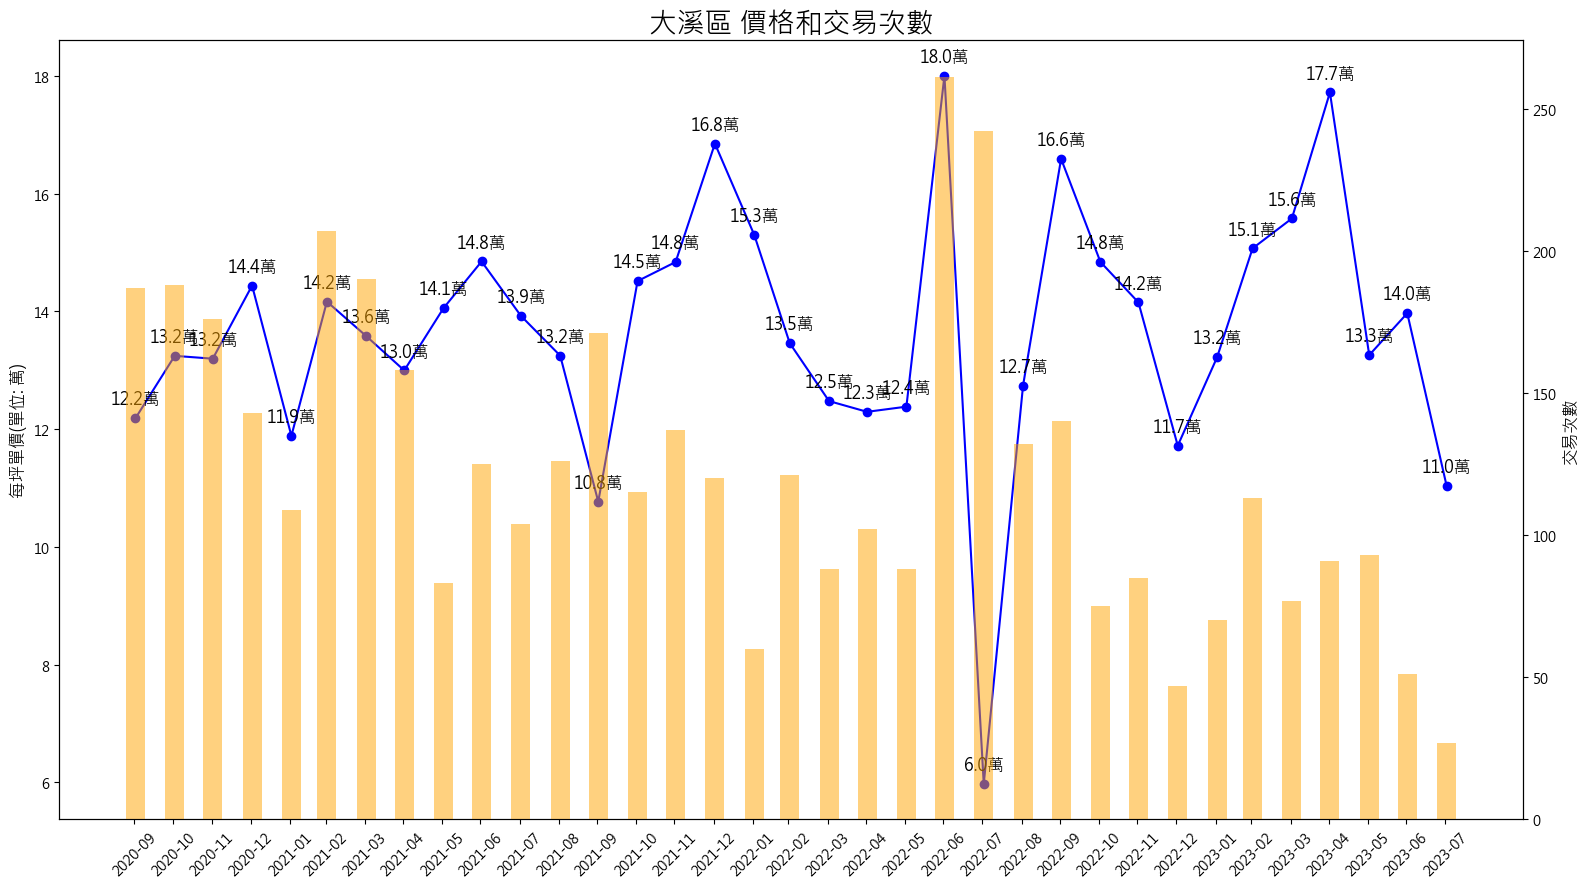

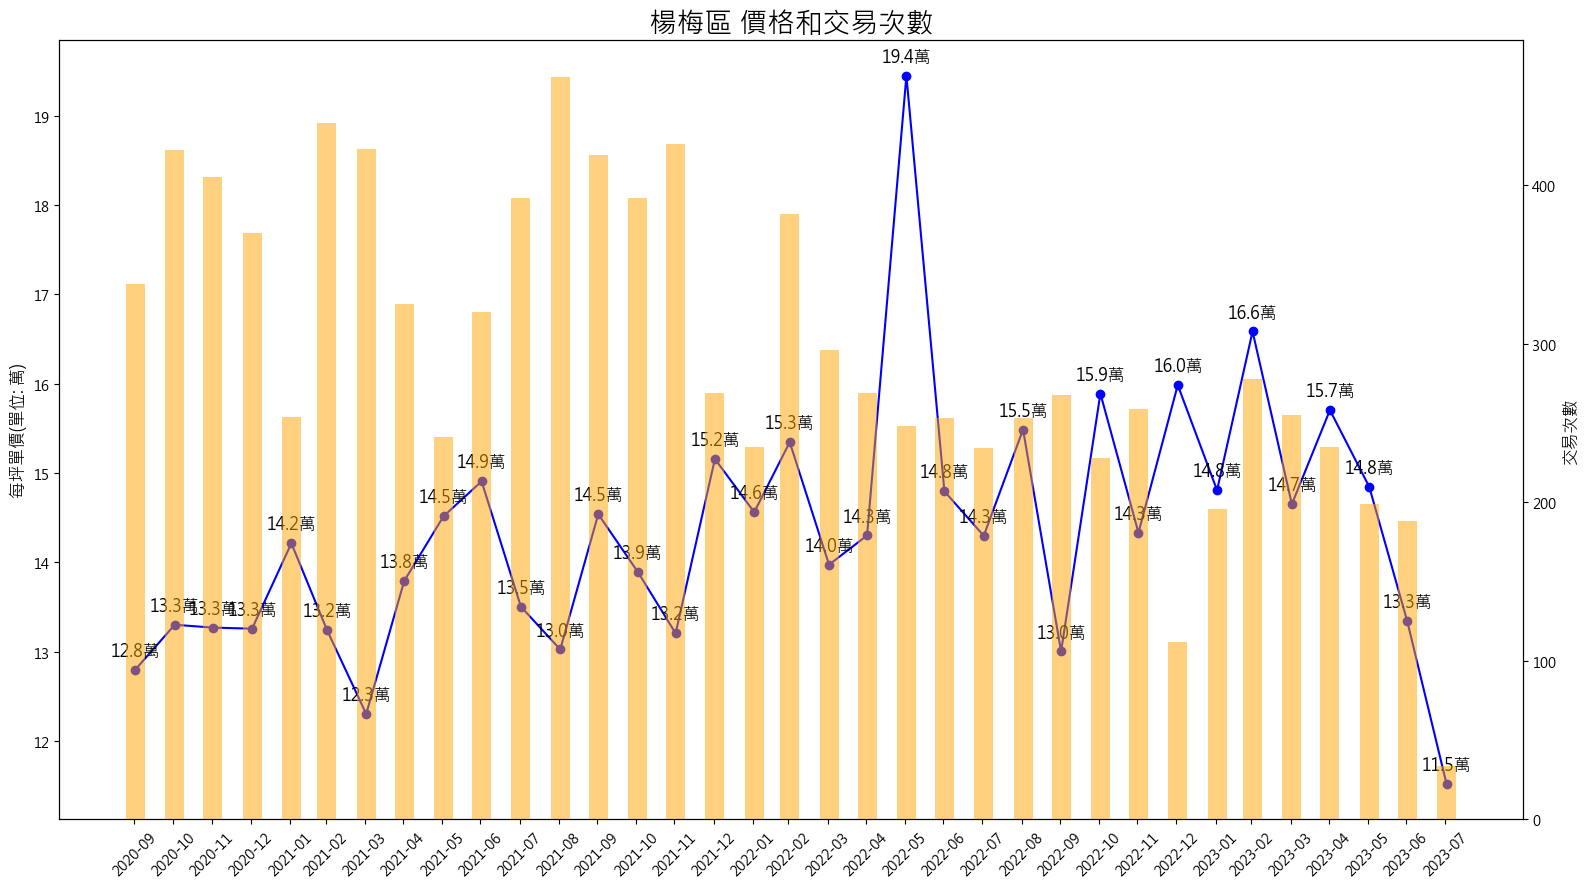

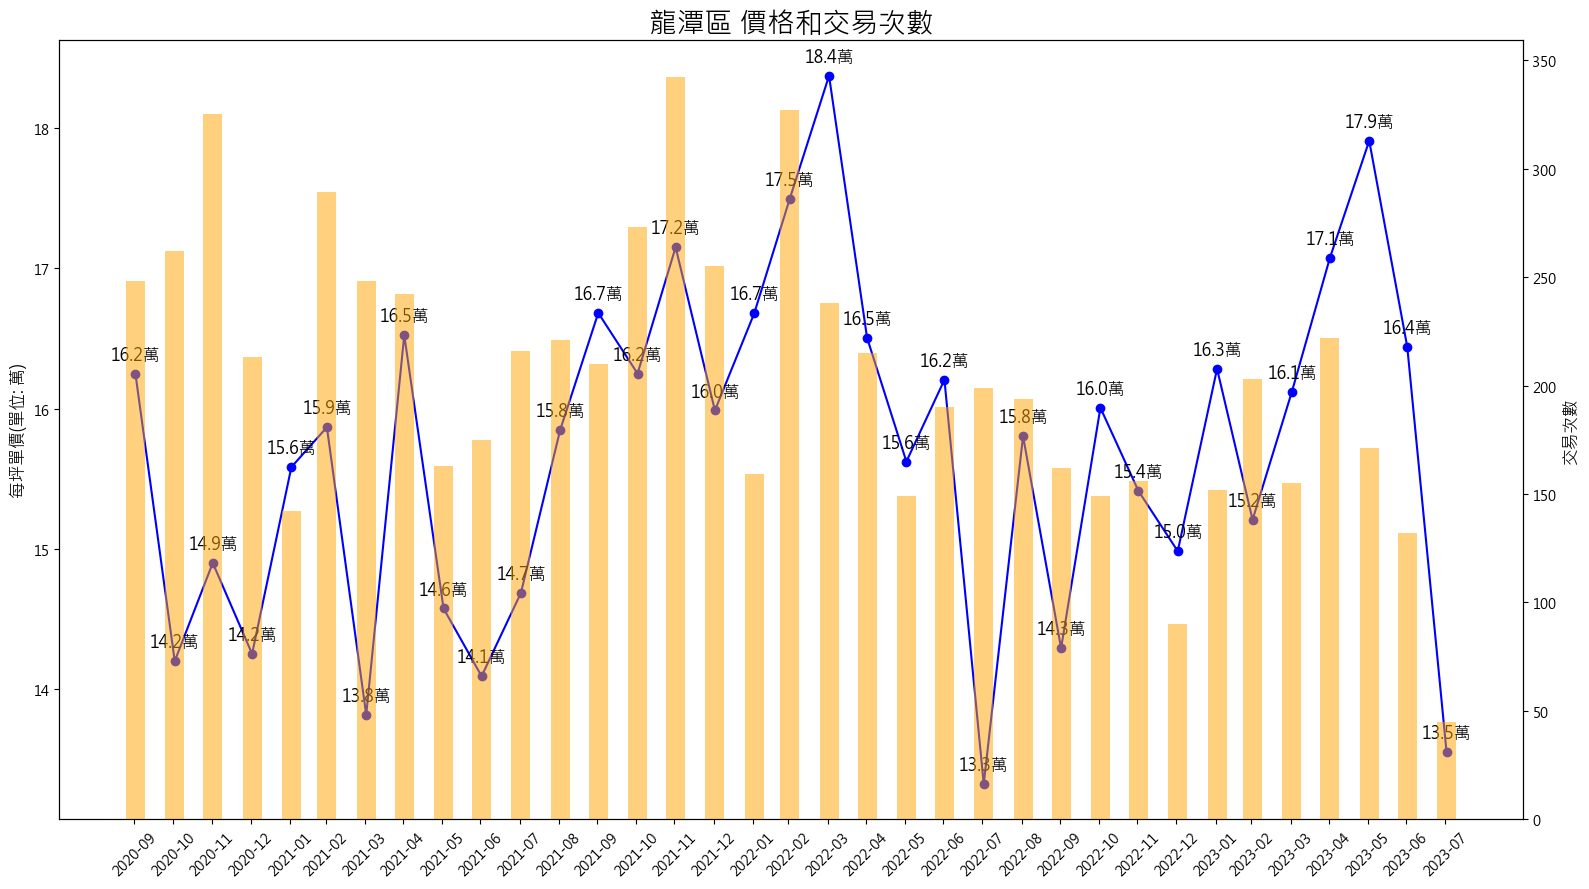

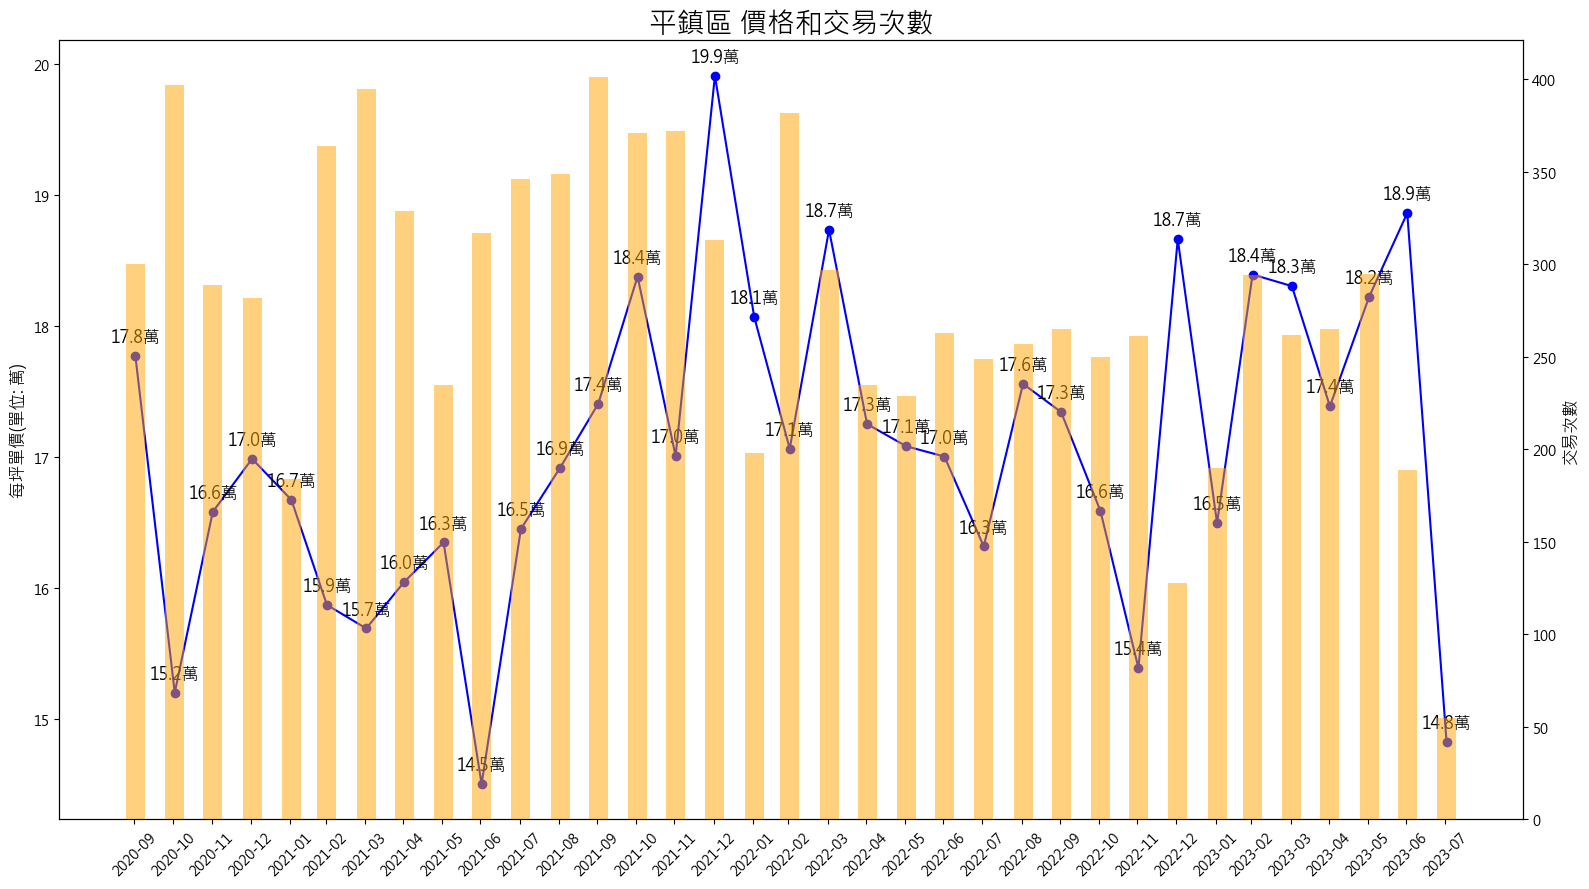

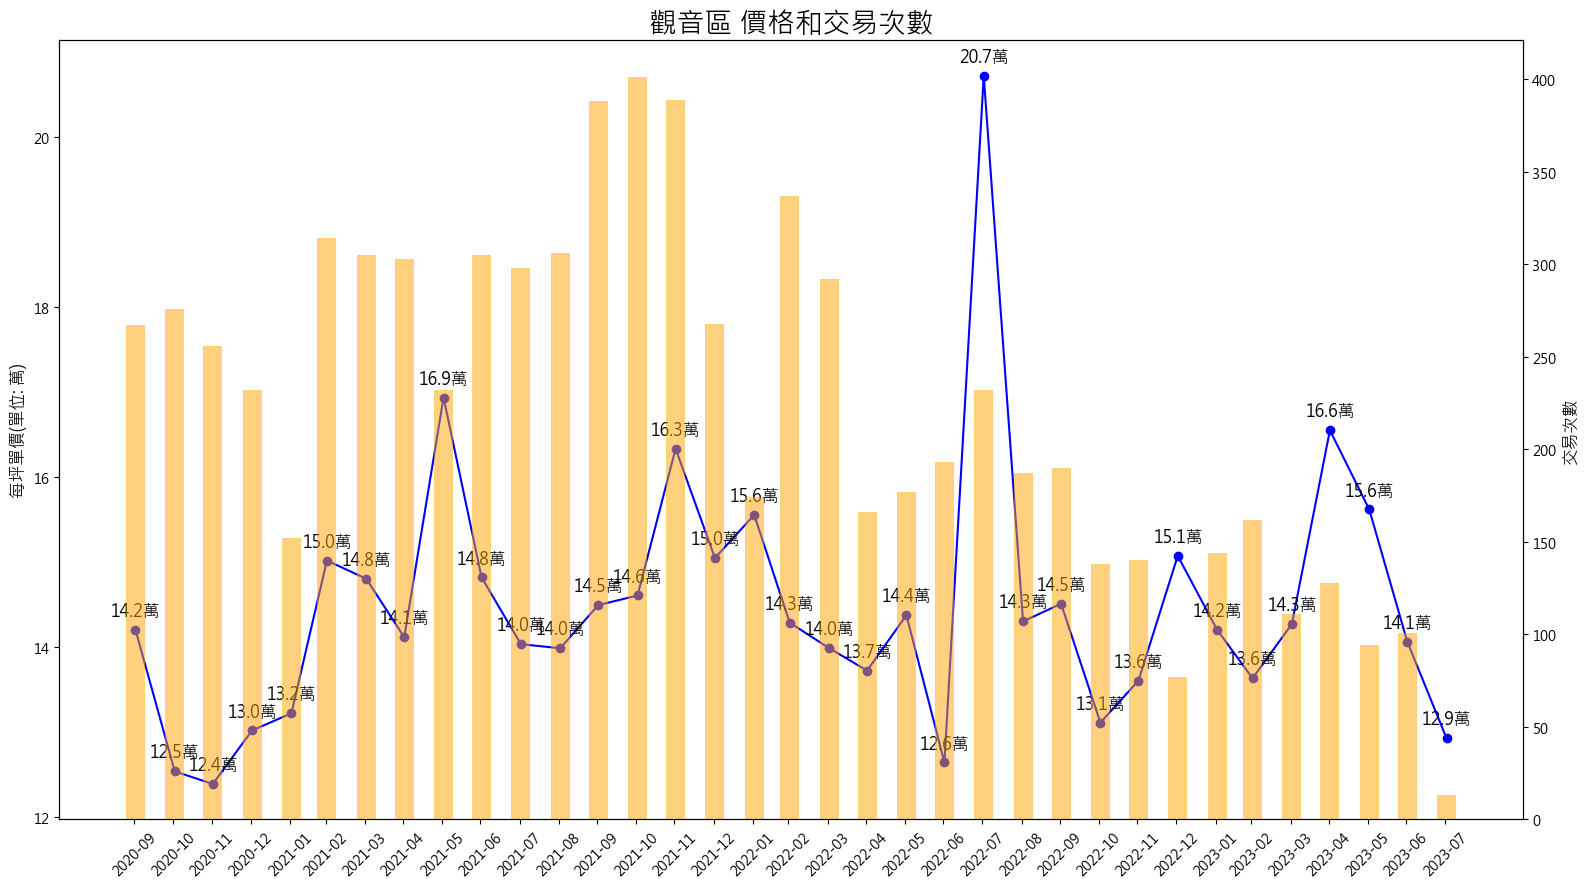

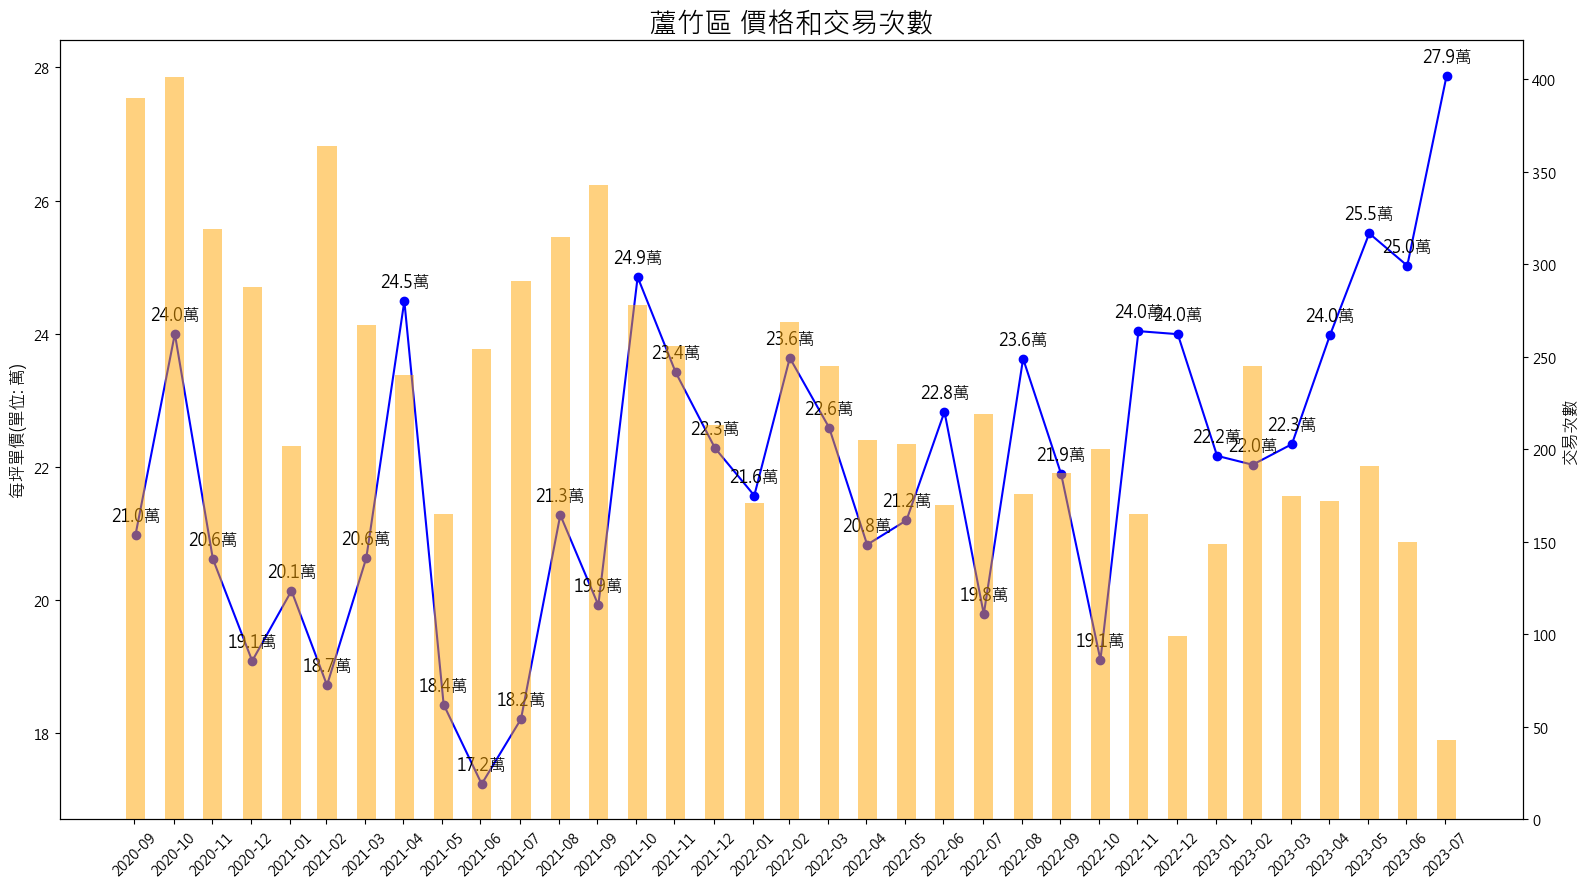

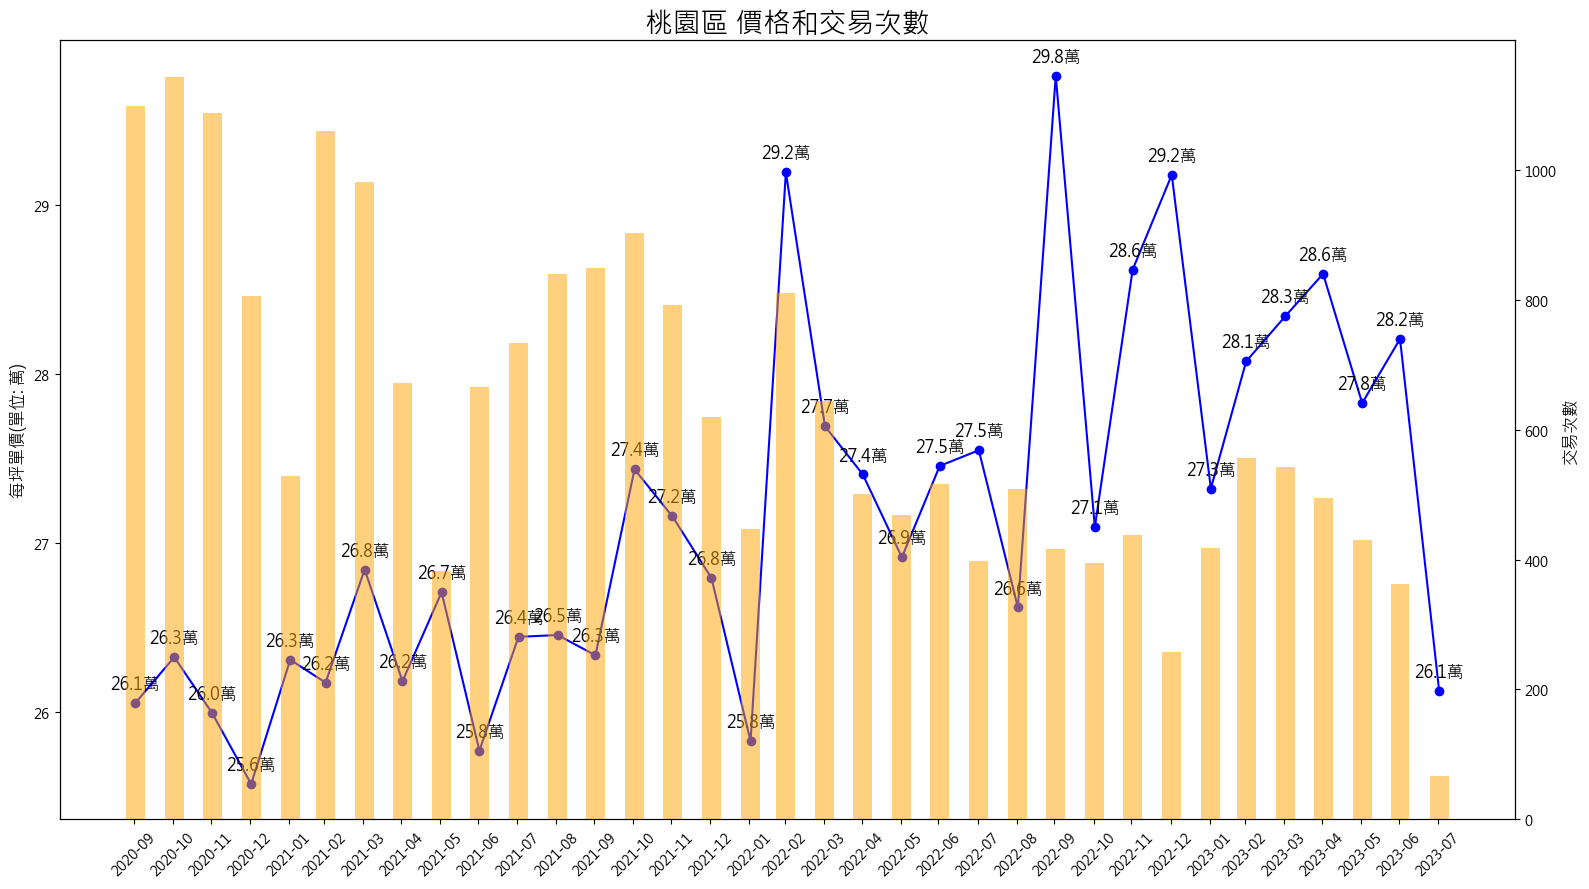

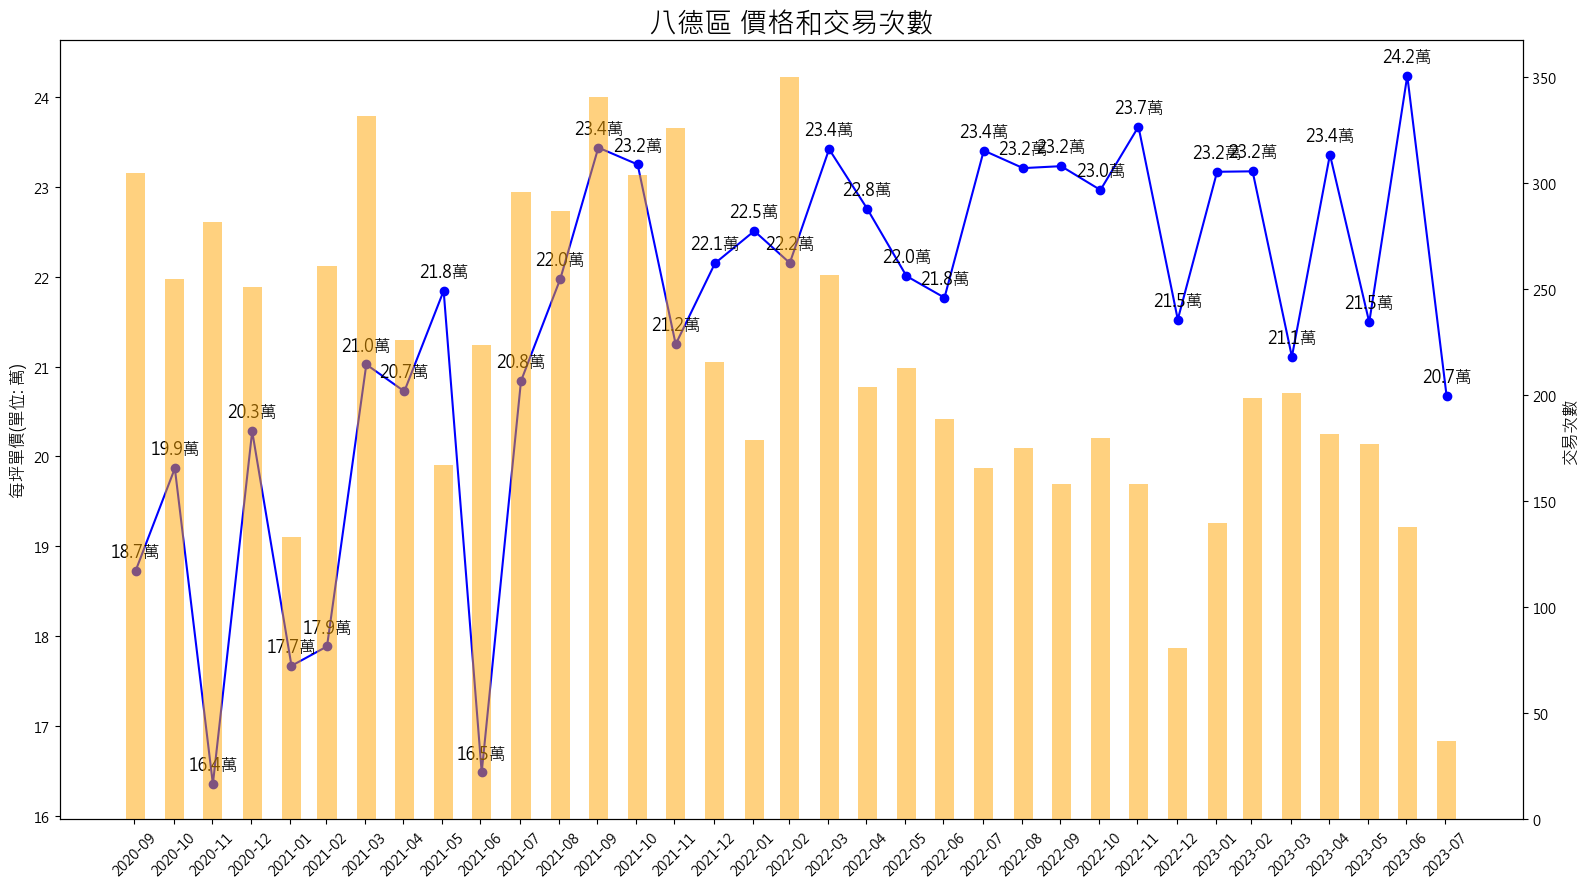

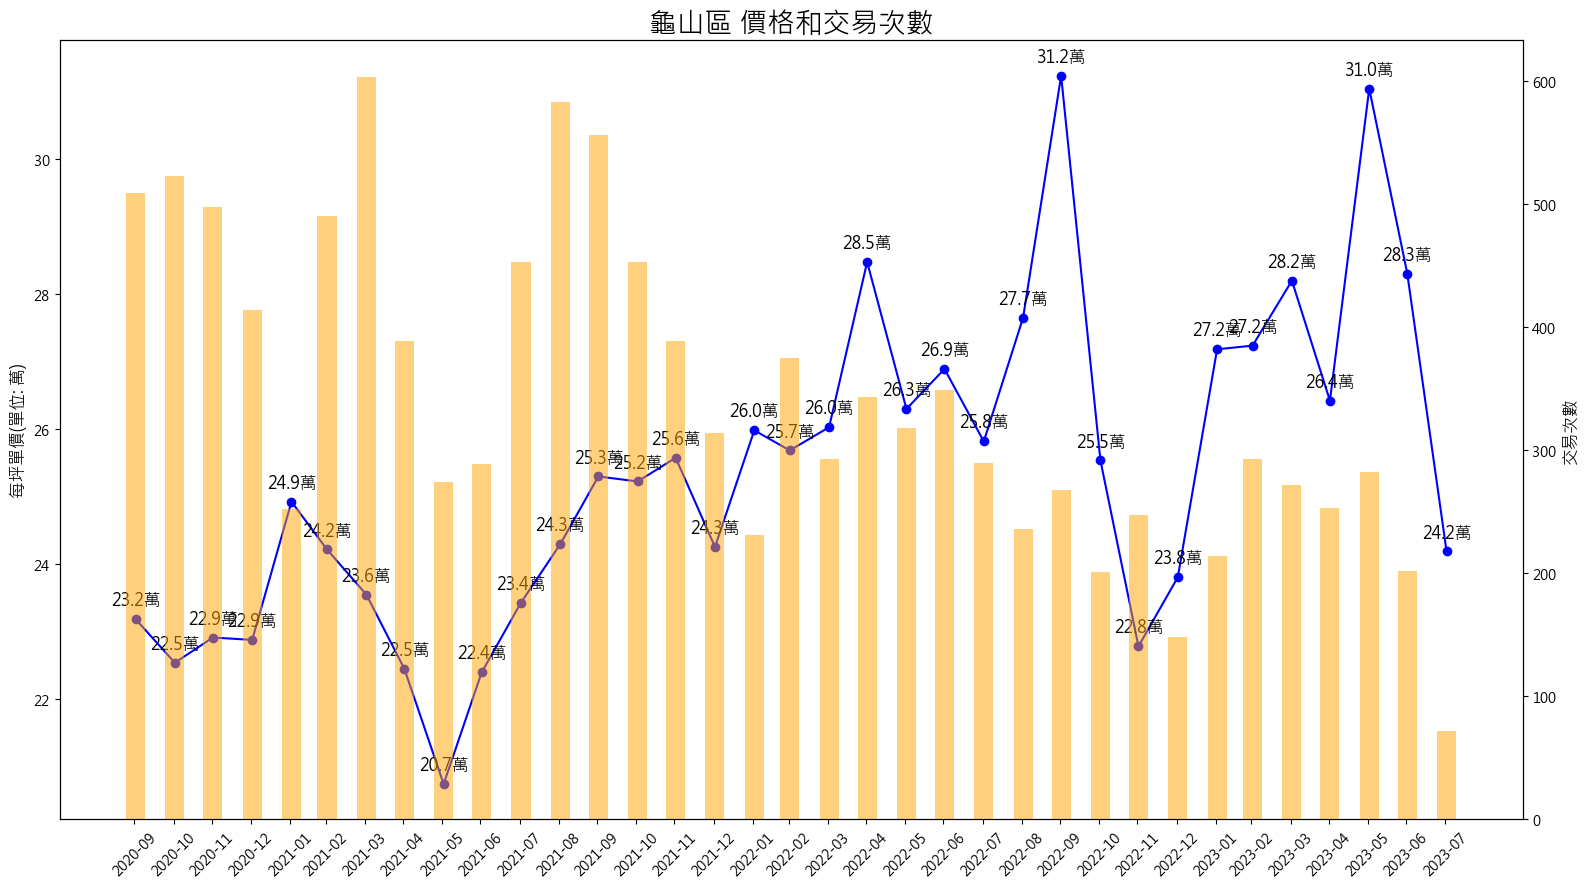

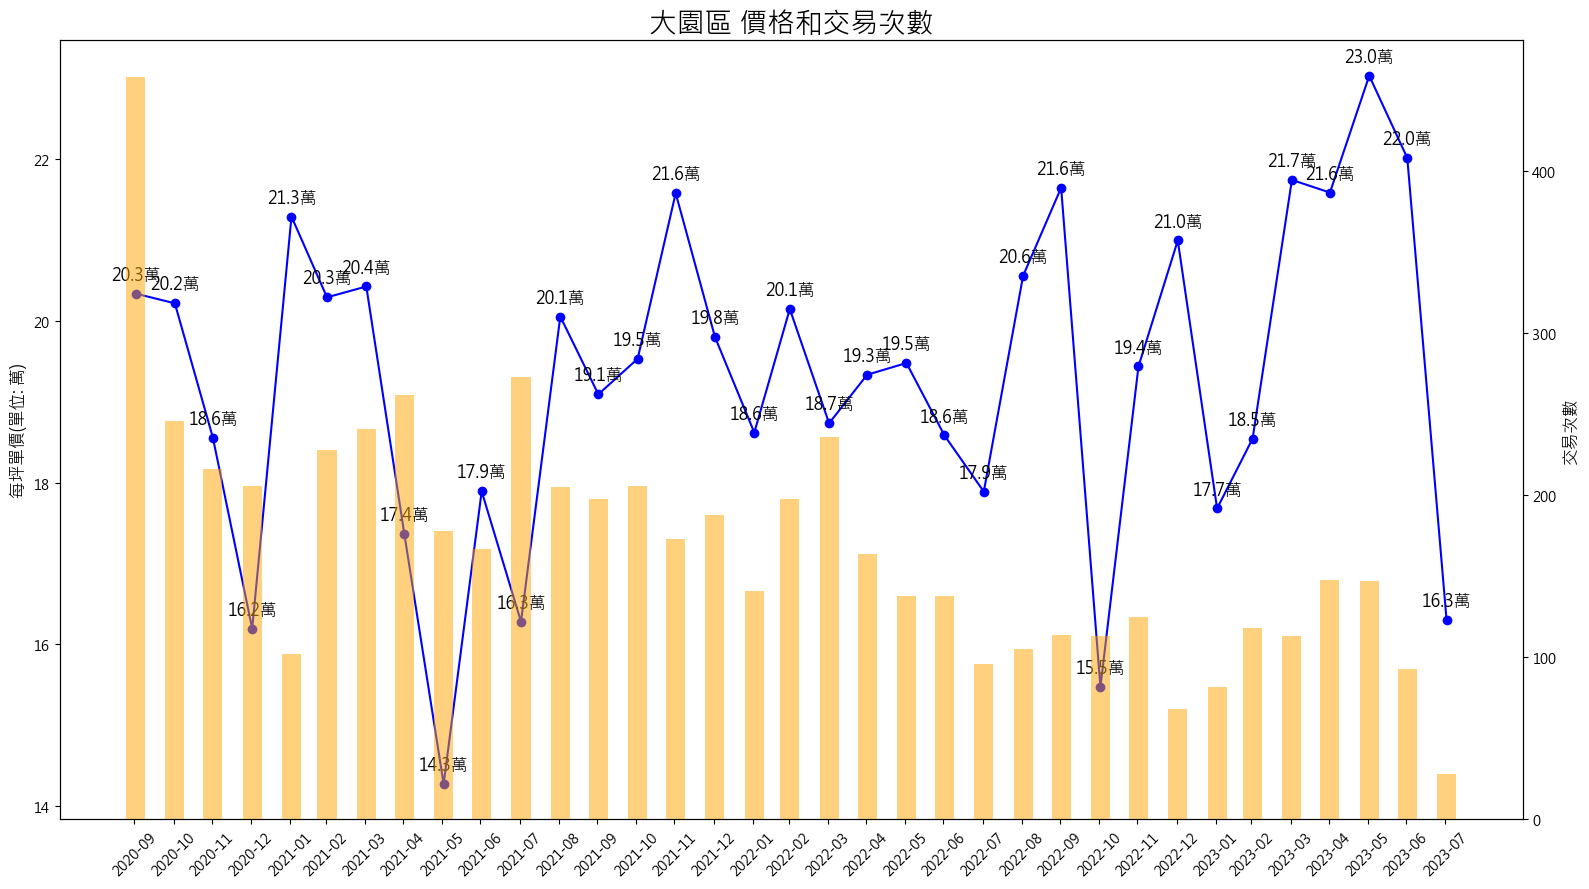

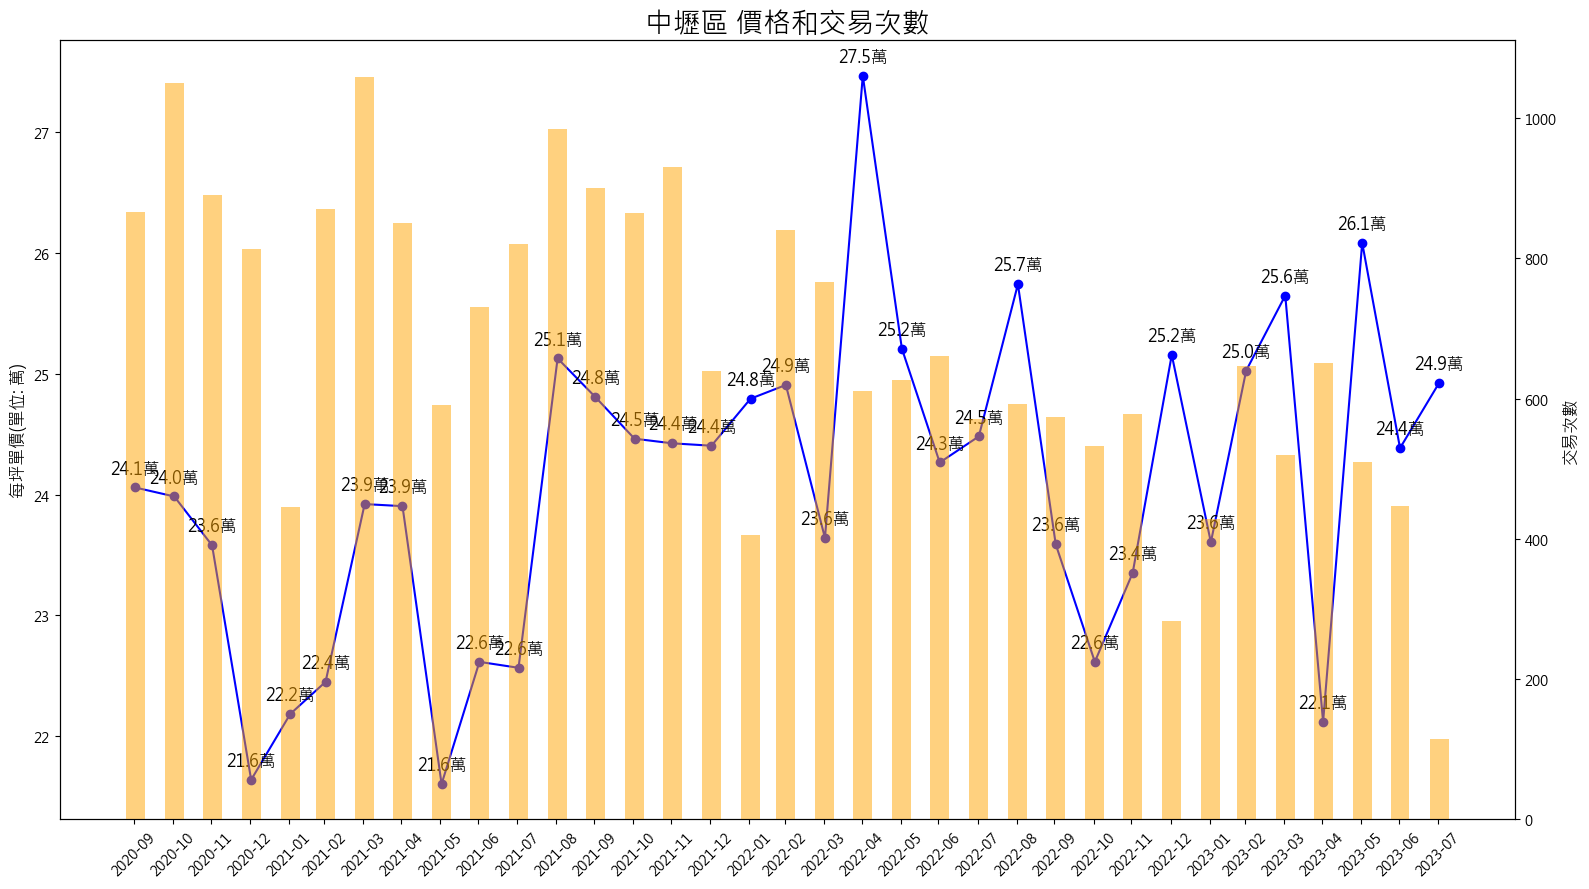

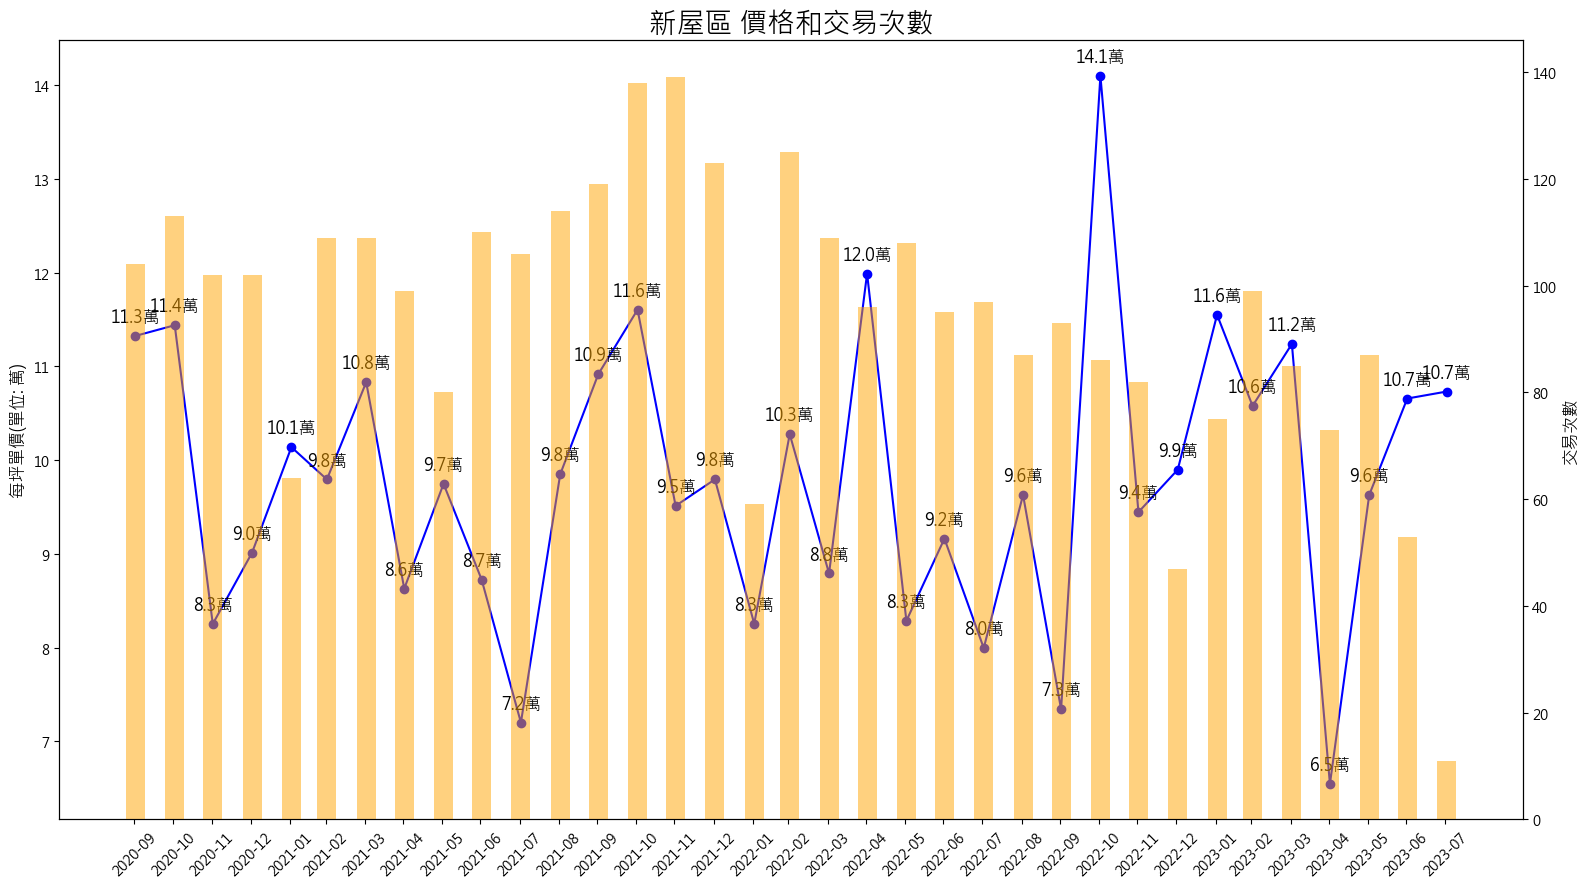

In [11]:
# Create a new DataFrame 'data3'
data3 = pd.DataFrame(data.groupby(['鄉鎮市區', 'Yearmonth'])['單價元坪'].mean()).reset_index()
data3['單價元坪'] = data3['單價元坪'] / 10000
dist = ['大溪區', '楊梅區', '龍潭區', '平鎮區', '觀音區', '蘆竹區', '桃園區', '八德區', '龜山區', '大園區', '中壢區', '新屋區']

for area in dist:
    # Create a copy of data3
    data3_copy = data3.copy()
    
    # Filter data for the specific district
    data3_copy = data3_copy[data3_copy['鄉鎮市區'] == area]

    # Convert the Yearmonth column to datetime
    data3_copy['Yearmonth'] = pd.to_datetime(data3_copy['Yearmonth'].astype(str), format='%Y-%m')

    # Sort the data by Yearmonth
    data3_copy = data3_copy.sort_values(by='Yearmonth')

    # Create a figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(16, 9))

    # Line chart for average price
    ax1.plot(data3_copy['Yearmonth'], data3_copy['單價元坪'], marker='o', linestyle='-', color='b', label='Average Price')
    ax1.set_ylabel(' Taiwanese ping(Unit: W)', fontsize=12)
    title = f'{area} 價格和Transaction Frequency'
    ax1.set_title(title, fontsize=20)
    ax1.tick_params(axis='x', labelrotation=45)

    # Annotate the data points on the line chart with data labels
    for i, txt in enumerate(data3_copy['單價元坪']):
        ax1.annotate(f'{txt:.1f}W', (data3_copy['Yearmonth'].iloc[i], data3_copy['單價元坪'].iloc[i]),
                     textcoords="offset points", xytext=(0, 10), ha='center', size=12)

    # Create a second y-axis for the bar chart
    ax2 = ax1.twinx()
    
    # Bar chart for transaction counts
    entry_counts = data[data['鄉鎮市區'] == area]['Yearmonth'].value_counts().sort_index()
    ax2.bar(data3_copy['Yearmonth'], entry_counts, alpha=0.5, color='orange', width=15, label='Transaction Counts')
    ax2.set_ylabel('Transaction Frequency', fontsize=12)

    # Set the x-axis ticks and labels to display from September 2020 to August 2023
    ax1.set_xticks(pd.date_range('2020-09-01', '2023-08-01', freq='M'))
    ax1.set_xticklabels([date.strftime('%Y-%m') for date in pd.date_range('2020-09-01', '2023-08-01', freq='M')],
                        rotation=45)

    # Adjust layout to prevent label overlap
    fig.tight_layout()

    # save the plot with title named
    path_to_save_file = Path().absolute()/"PNG"
    path_to_save_file.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
    filename = f'{title}.png'
    full_path = path_to_save_file/filename
    plt.savefig(full_path)

    # Show the chart
    plt.show()

In [12]:
for area in dist:
    # Create a copy of data3
    data3_copy = data.copy()
    data3_copy = data3_copy[data3_copy['鄉鎮市區'] == area].groupby(['鄉鎮市區', 'Yearmonth']).size().reset_index(name='Transaction_Count')
    print(area)
    print(data3_copy[['Yearmonth', 'Transaction_Count']].transpose())

大溪區
                        0        1        2        3        4        5   \
Yearmonth          2020-10  2020-11  2020-12  2021-01  2021-02  2021-03   
Transaction_Count      187      188      176      143      109      207   

                        6        7        8        9   ...       25       26  \
Yearmonth          2021-04  2021-05  2021-06  2021-07  ...  2022-11  2022-12   
Transaction_Count      190      158       83      125  ...       75       85   

                        27       28       29       30       31       32  \
Yearmonth          2023-01  2023-02  2023-03  2023-04  2023-05  2023-06   
Transaction_Count       47       70      113       77       91       93   

                        33       34  
Yearmonth          2023-07  2023-08  
Transaction_Count       51       27  

[2 rows x 35 columns]
楊梅區
                        0        1        2        3        4        5   \
Yearmonth          2020-10  2020-11  2020-12  2021-01  2021-02  2021-03   
Transaction_

In [13]:
## Export file as CSV
# path_to_save_file = Path().absolute()/"CSV"
# filename = '2020Q3-2023Q3_Taoyaun_property_data.csv' # save the plot with title named
# full_path = path_to_save_file/filename  # Constructing the full path

# data.to_csv(full_path, index=False)


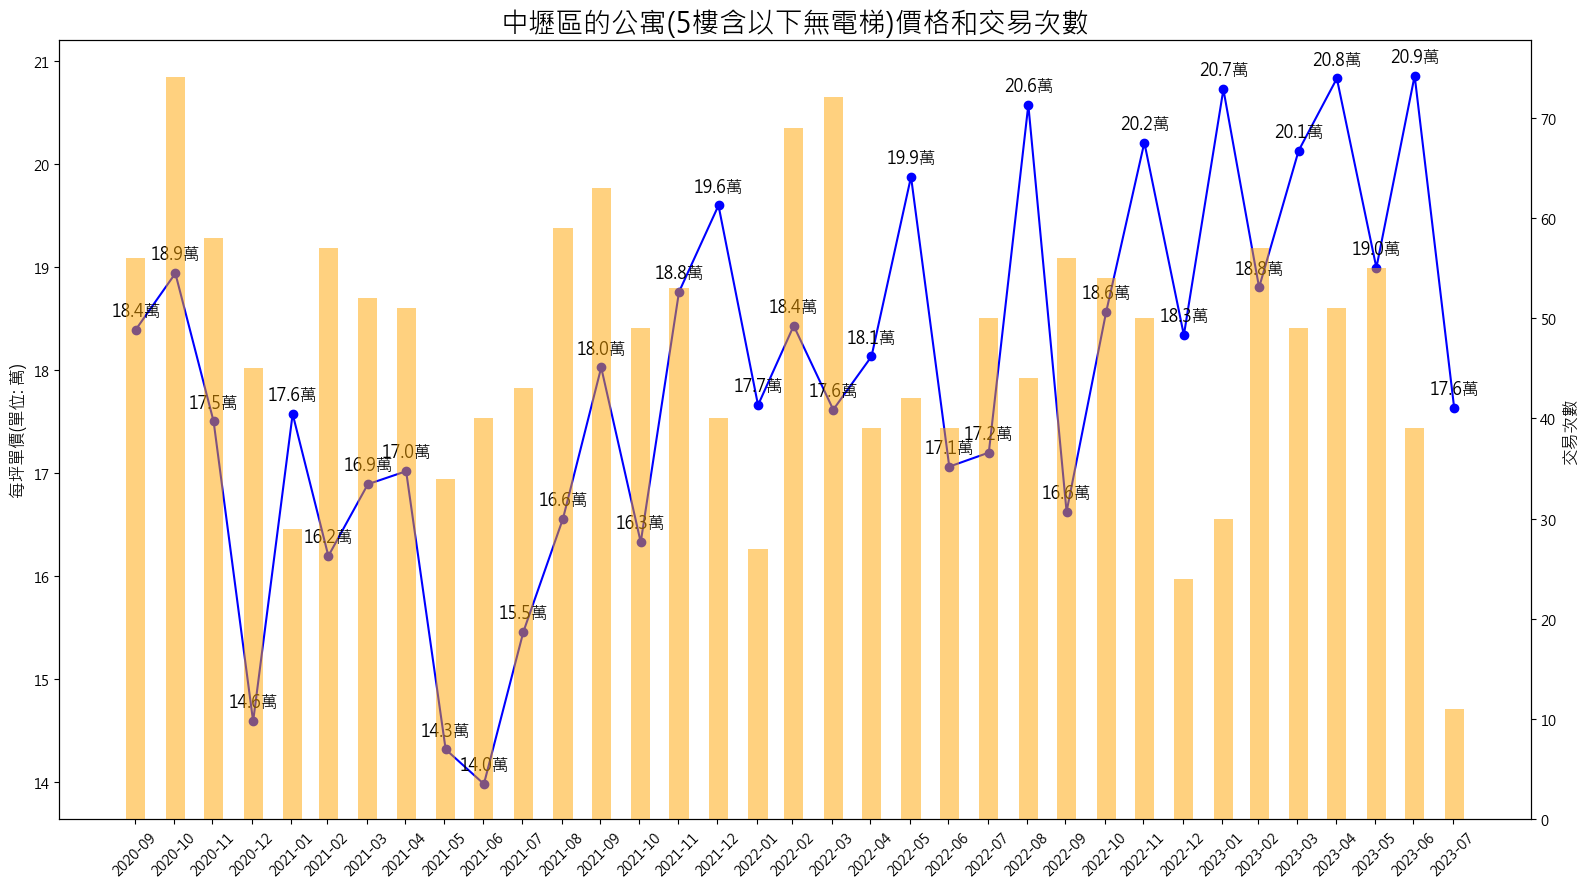

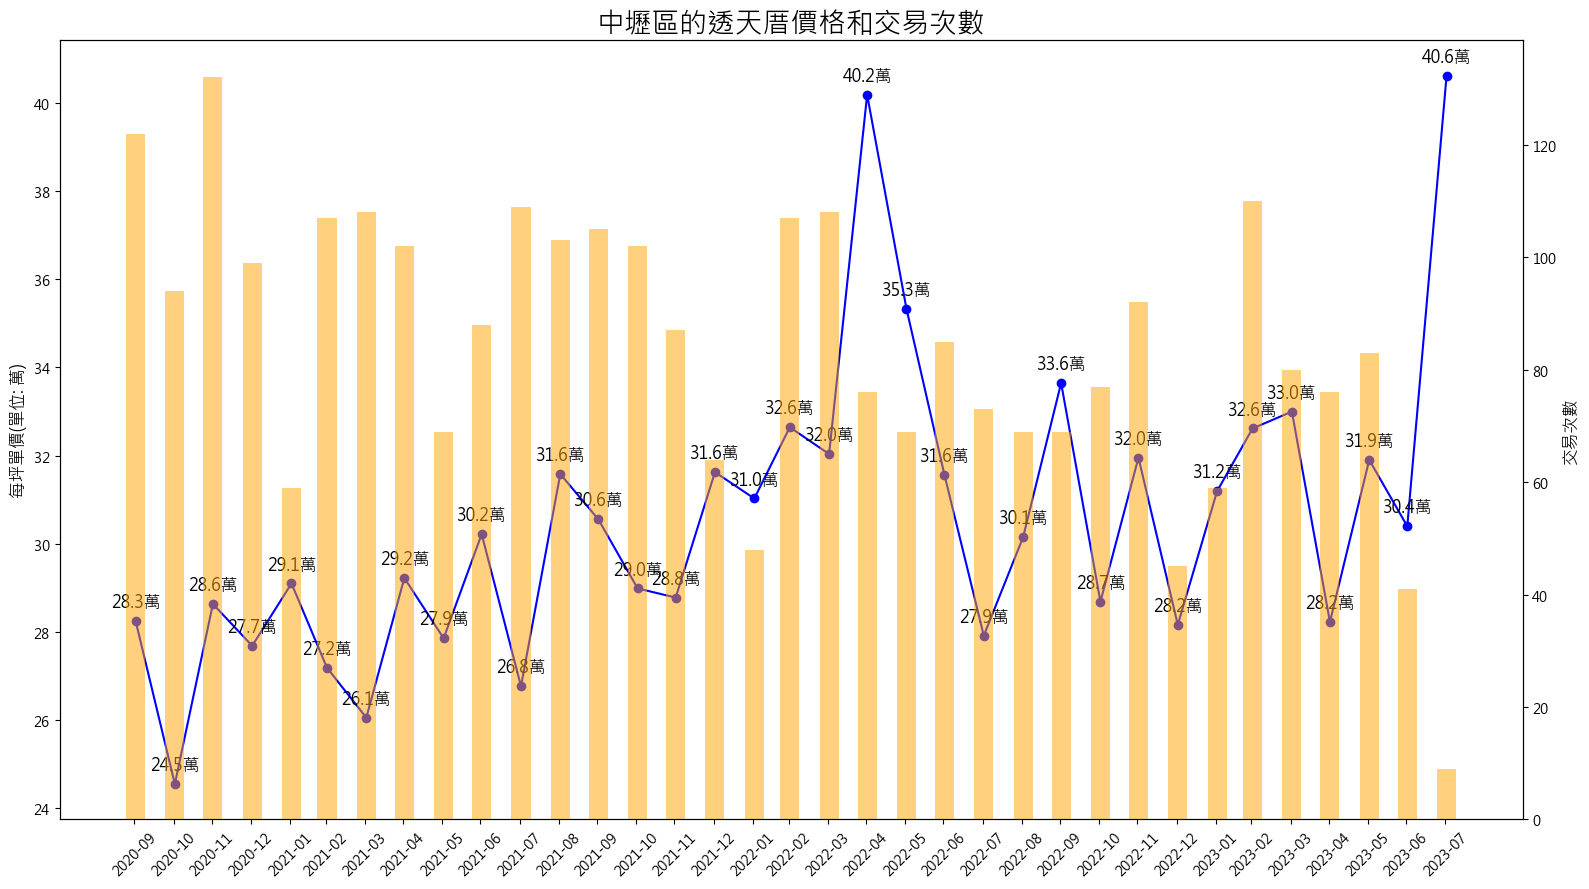

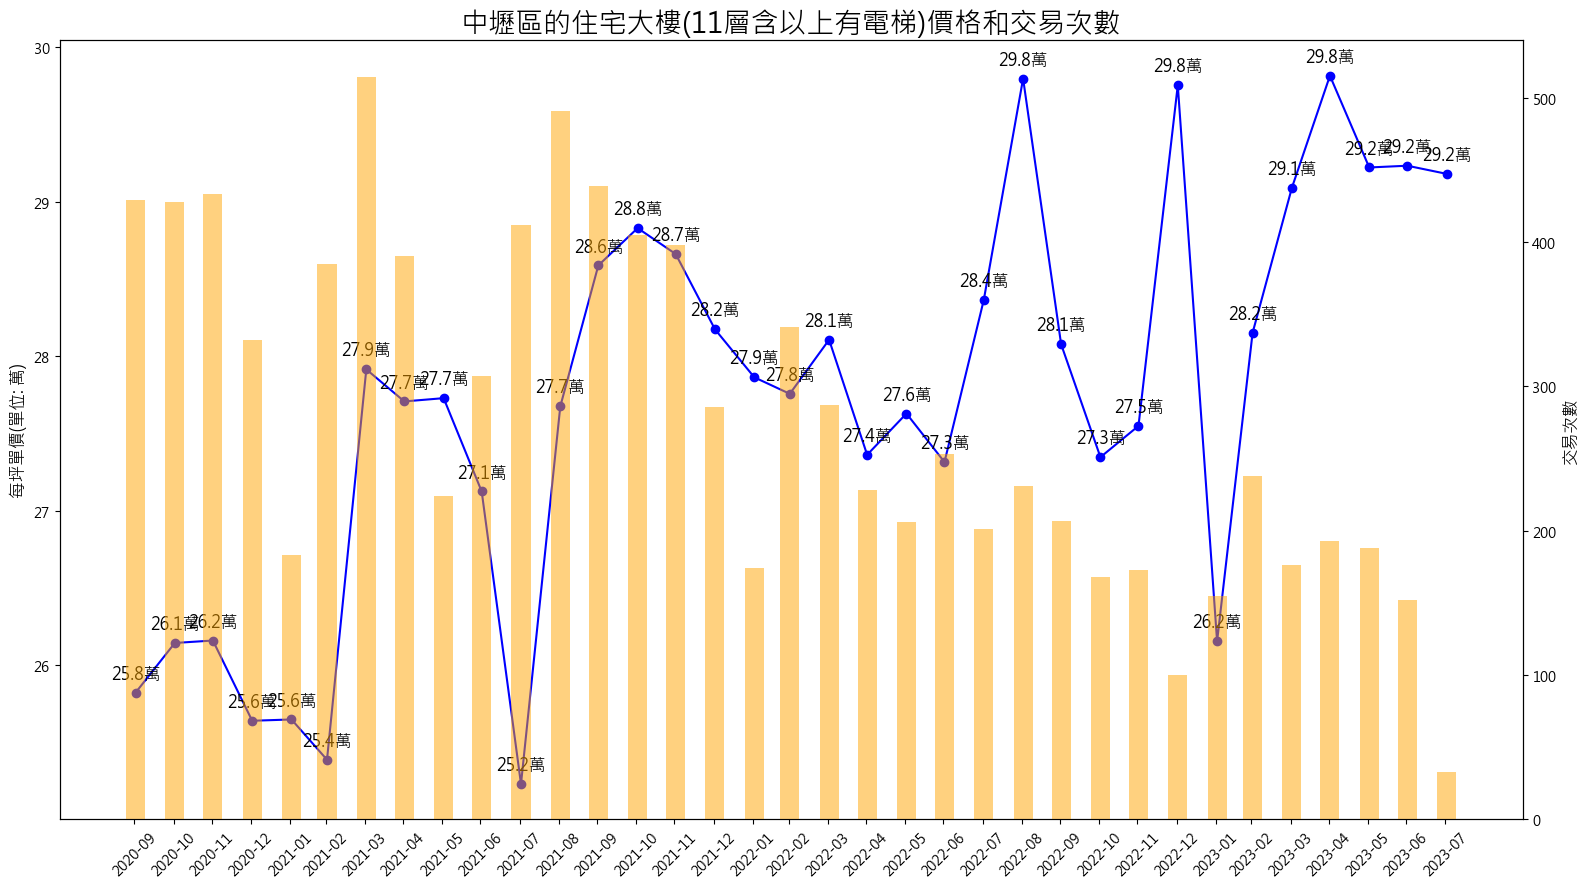

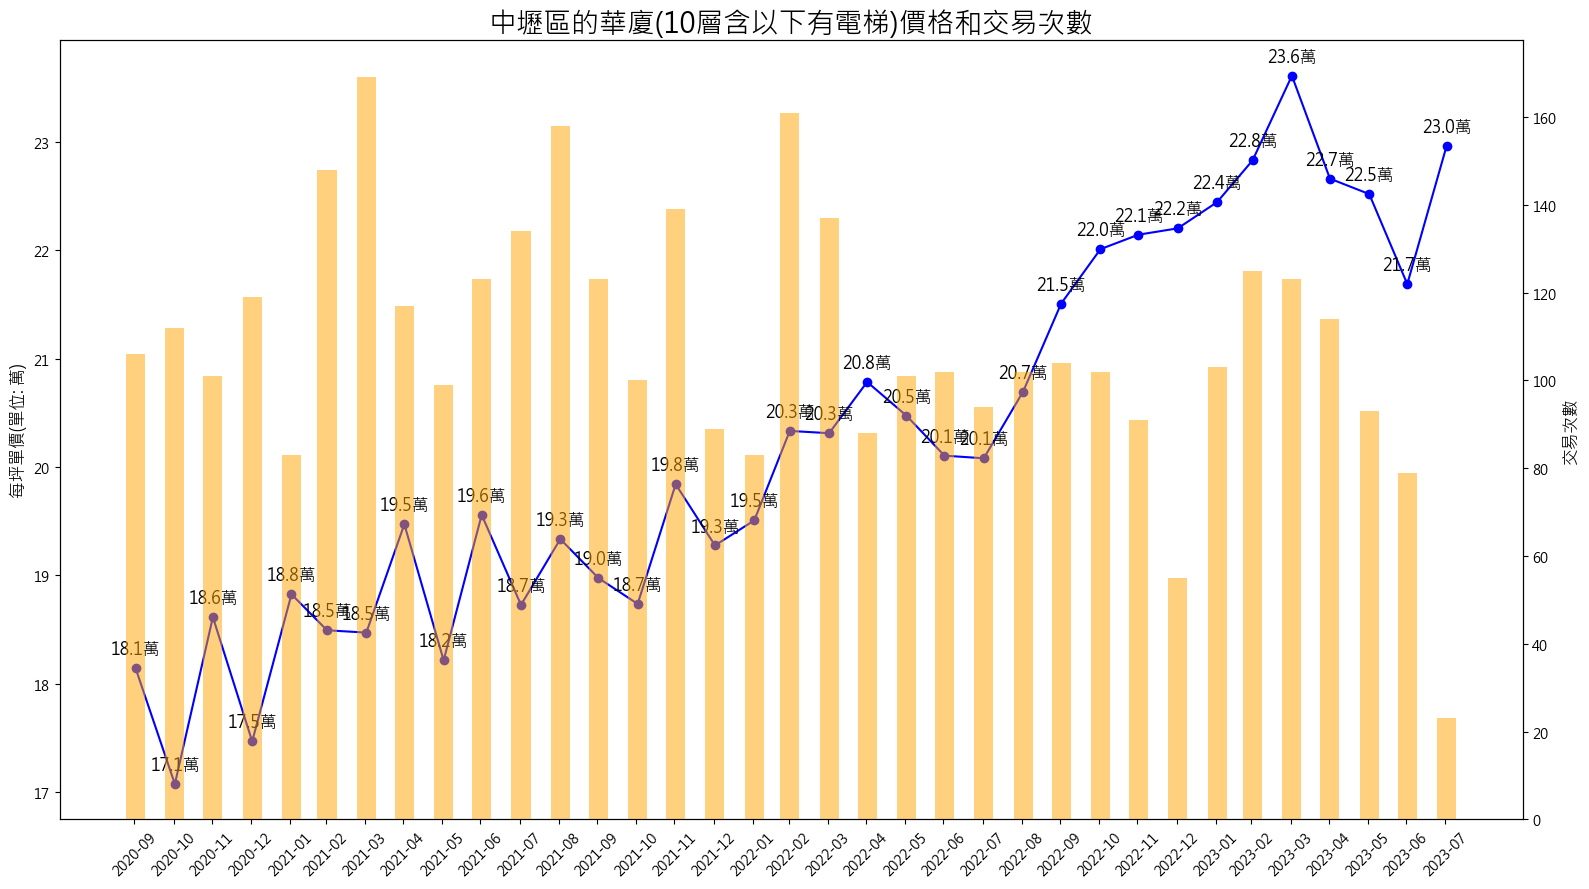

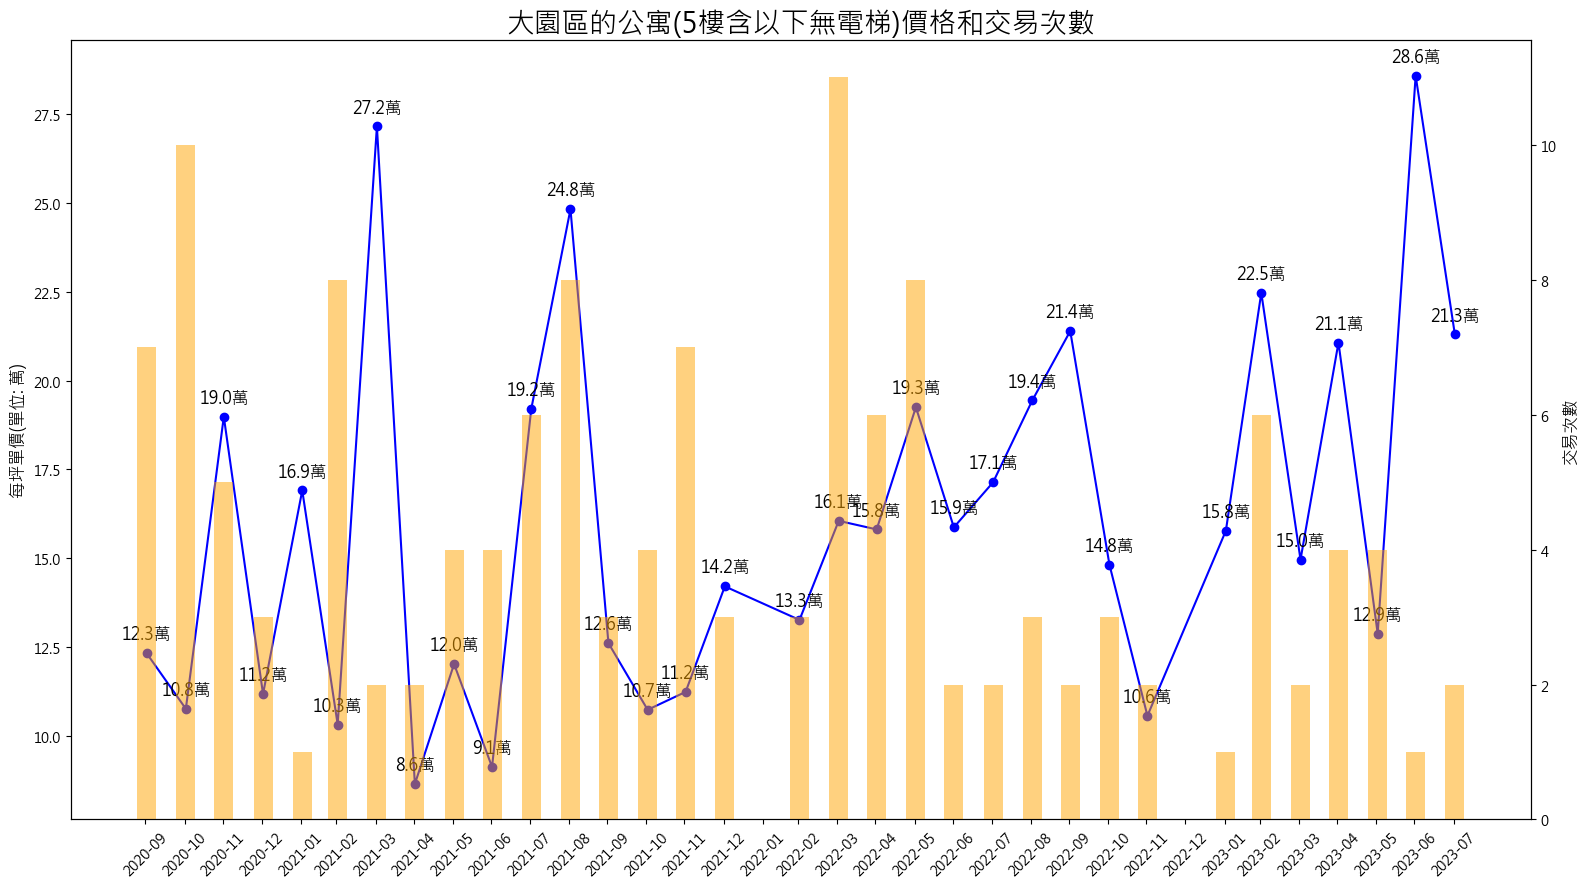

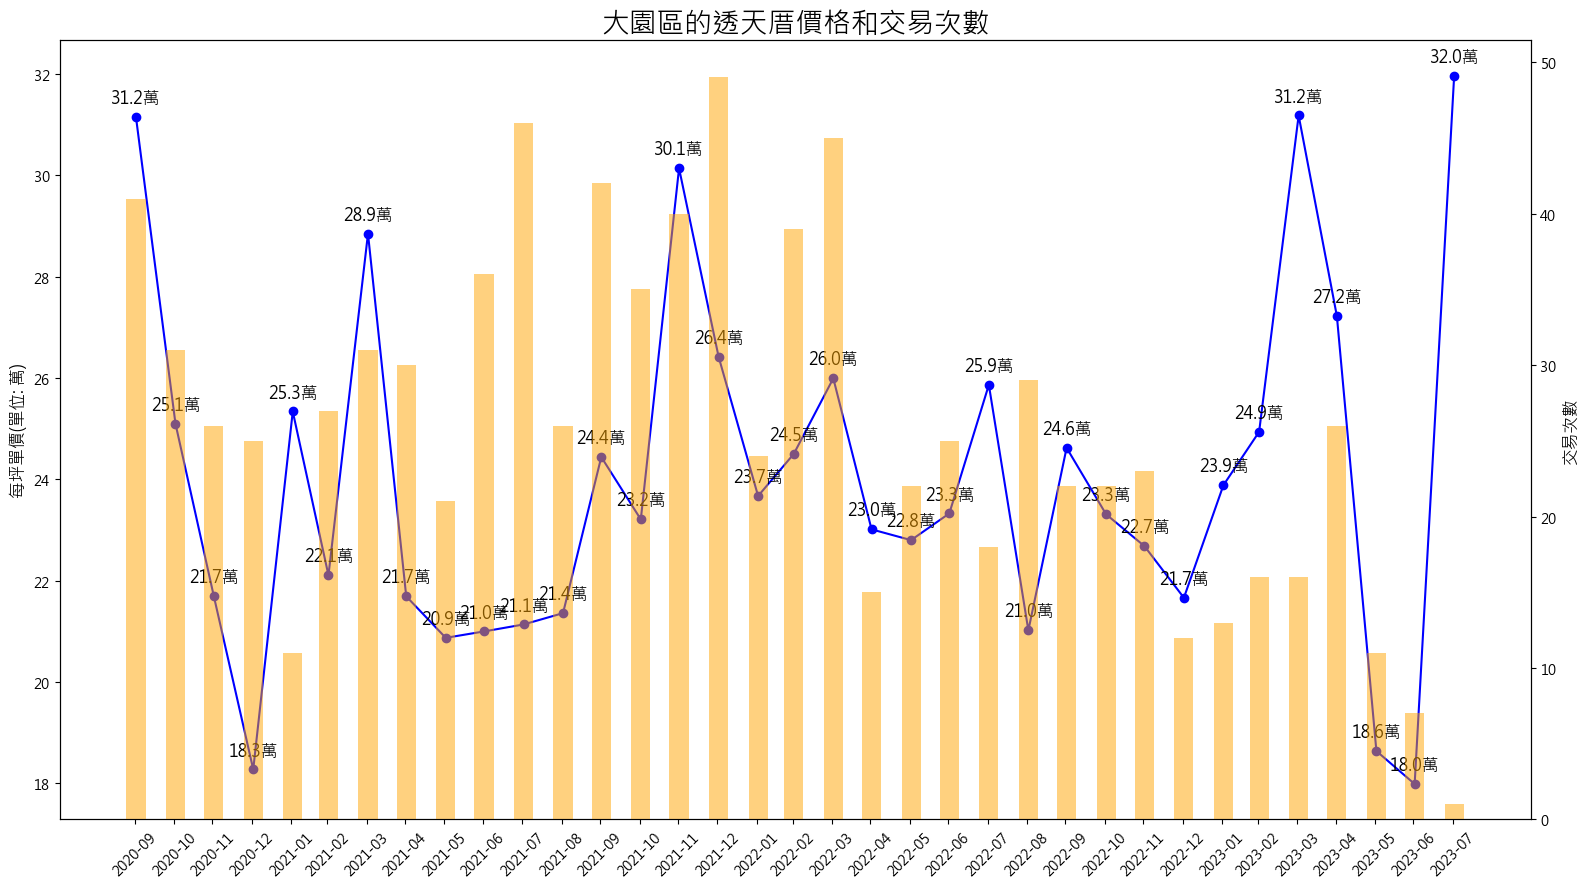

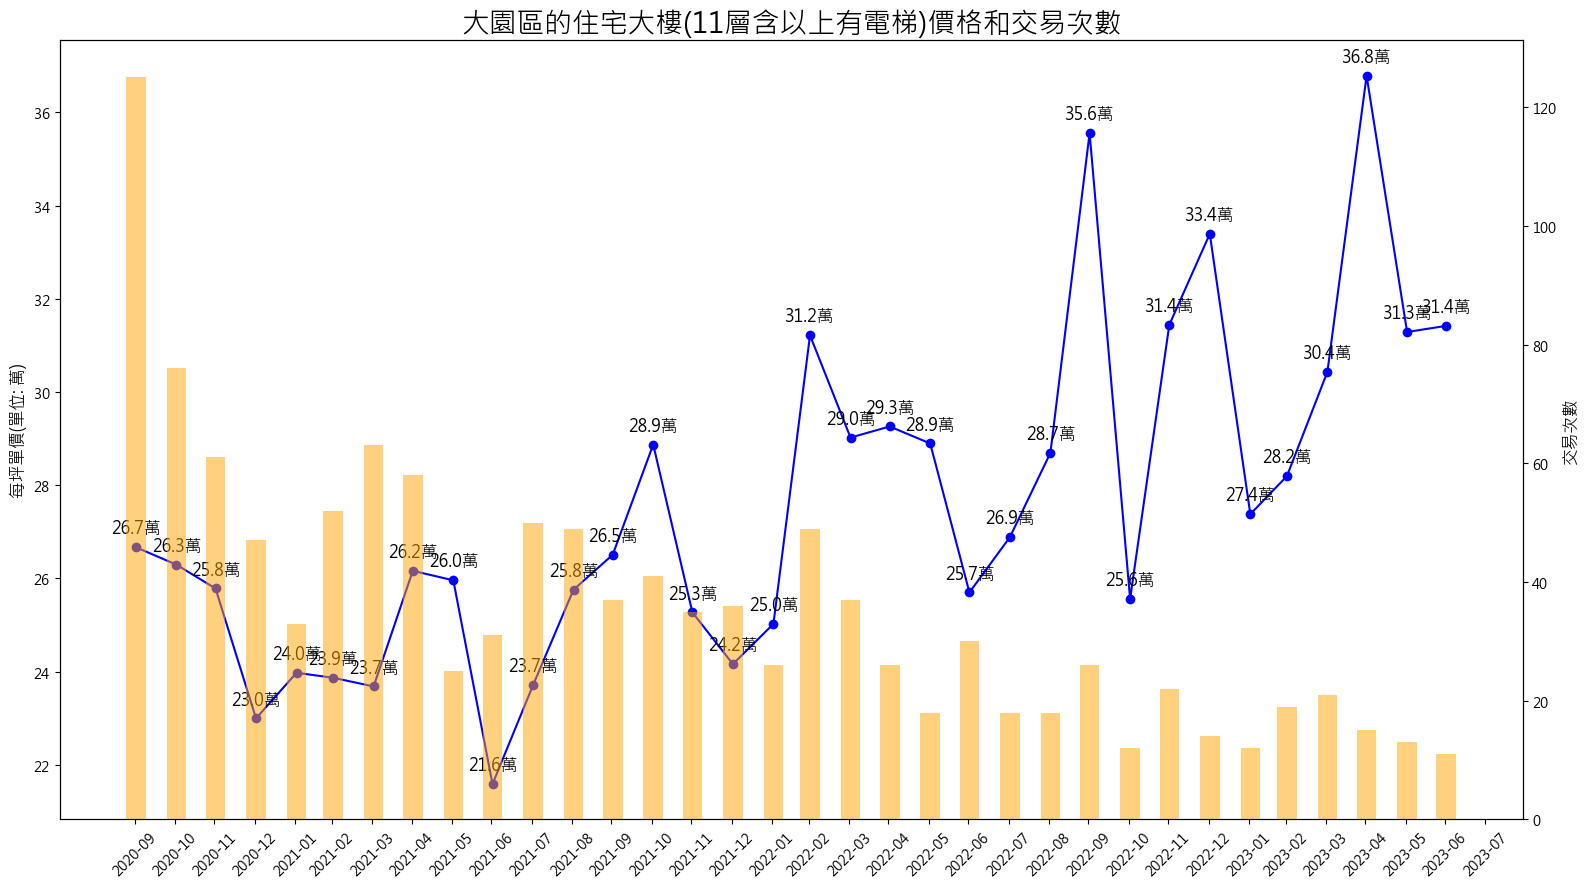

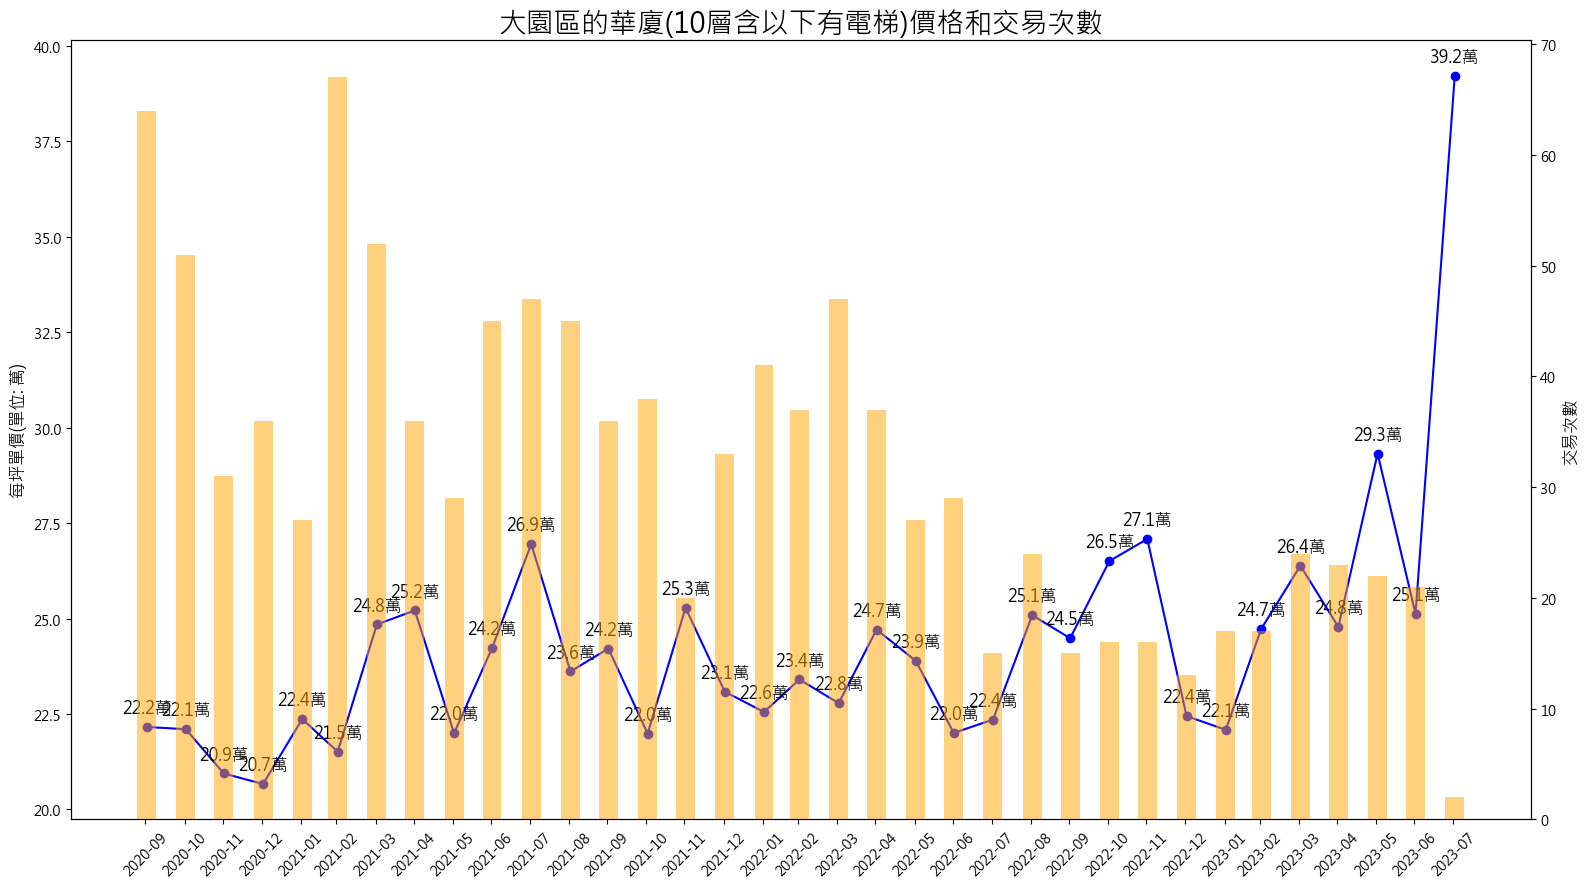

In [14]:
# 針對大園區和中壢區再做分析

dist = ['中壢區', '大園區']
property_type = ['公寓(5樓含以下無電梯)', '透天厝', '住宅大樓(11層含以上有電梯)', '華廈(10層含以下有電梯)']

data4 = pd.DataFrame(data.groupby(['鄉鎮市區', '建物型態', 'Yearmonth'])['單價元坪'].mean()).reset_index()

for area in dist:
    for type in property_type:
        data4_copy = data4.copy()
        # data4_copy = pd.DataFrame(data.groupby(['建物型態', 'Yearmonth'])['單價元坪'].mean()).reset_index()
        data4_copy['單價元坪'] = data4_copy['單價元坪'] / 10000
        data4_copy = data4_copy[(data4_copy['鄉鎮市區'] == area) & (data4_copy['建物型態'] == type)]

        # Convert the Yearmonth column to datetime
        data4_copy.loc[:, 'Yearmonth'] = pd.to_datetime(data4_copy['Yearmonth'].astype(str), format='%Y-%m')

        # Sort the data by Yearmonth
        data4_copy = data4_copy.sort_values(by='Yearmonth')

        # Create a figure with two y-axes
        fig, ax1 = plt.subplots(figsize=(16, 9))

        # Line chart for average price
        ax1.plot(data4_copy['Yearmonth'], data4_copy['單價元坪'], marker='o', linestyle='-', color='b', label='Average Price')
        ax1.set_ylabel(' Taiwanese ping(Unit: W)', fontsize=12)
        title = f'{area}的{type}價格和Transaction Frequency'
        ax1.set_title(title, fontsize=20)
        ax1.tick_params(axis='x', labelrotation=45)

        # Annotate the data points on the line chart with data labels
        for i, txt in enumerate(data4_copy['單價元坪']):
            ax1.annotate(f'{txt:.1f}W', (data4_copy['Yearmonth'].iloc[i], data4_copy['單價元坪'].iloc[i]),
                        textcoords="offset points", xytext=(0, 10), ha='center', size=12)

        # Create a second y-axis for the bar chart
        ax2 = ax1.twinx()
        
        # Bar chart for transaction counts
        entry_counts = data[(data['鄉鎮市區'] == area) & (data['建物型態'] == type)]['Yearmonth'].value_counts().sort_index()
        ax2.bar(data4_copy['Yearmonth'], entry_counts, alpha=0.5, color='orange', width=15, label='Transaction Counts')
        ax2.set_ylabel('Transaction Frequency', fontsize=12)

        # Set the x-axis ticks and labels to display from September 2020 to August 2023
        ax1.set_xticks(pd.date_range('2020-09-01', '2023-08-01', freq='M'))
        ax1.set_xticklabels([date.strftime('%Y-%m') for date in pd.date_range('2020-09-01', '2023-08-01', freq='M')],rotation=45)

        # Adjust layout to prevent label overlap
        fig.tight_layout()

        # save the plot with title named
        path_to_save_file = Path().absolute()/"PNG"
        path_to_save_file.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
        filename = f'{title}.png'
        full_path = path_to_save_file/filename
        plt.savefig(full_path)

        # Show the chart
        plt.show()
        